In [1]:
import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80,facecolor='white')

from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.9.0 pandas==1.4.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
adata = sc.read("PBMC.h5ad")
adata

AnnData object with n_obs × n_vars = 14039 × 1000
    obs: 'batch', 'log_counts', 'n_counts', 'n_genes', 'sample', 'celltype', 'detailed_celltype'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

# Process Data

In [3]:
dataset = GeneVectorDataset(adata)

Loading Expression.


100%|██████████| 1051348/1051348 [00:01<00:00, 722682.21it/s]


Reindexing Cooc


100%|██████████| 14039/14039 [00:00<00:00, 46560.74it/s]


# Setup Model

In [4]:
cmps = GeneVector(dataset,
                  output_file="pbmc.vec",
                  emb_dimension=100,
                  batch_size=10000)

Generating inputs and outputs.


  0%|          | 775/477753 [00:00<02:34, 3080.53it/s]/Users/nceglia/miniconda/lib/python3.9/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s
/Users/nceglia/miniconda/lib/python3.9/site-packages/genevector-0.0.1-py3.9.egg/genevector/data.py:207: RuntimeWarning: divide by zero encountered in log2
  pmi = numpy.log2(np.sum(pxy[nzs] * (pxy[nzs] / px_py[nzs])))
/Users/nceglia/miniconda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nceglia/miniconda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [00:00<00:00, 1494.45it/s]


# Train Network

In [102]:
cmps.train(2000,threshold=0)
embed = GeneEmbedding("pbmc.vec", dataset, vector="average")
print(embed.compute_similarities("CD8A")[:30])

Epoch: 1/2000 	 Batch: 100/99 	 Loss: 0.48840298056602477
Epoch 1303 	Delta-> 0.48840298056602477 	Loss: 0.48840298056602477
Epoch: 2/2000 	 Batch: 100/99 	 Loss: 0.48411417156457903
Epoch 1304 	Delta-> 0.004288809001445737 	Loss: 0.48411417156457903
Epoch: 3/2000 	 Batch: 100/99 	 Loss: 0.4856049805879593
Epoch 1305 	Delta-> 0.0014908090233802795 	Loss: 0.4856049805879593
Epoch: 4/2000 	 Batch: 100/99 	 Loss: 0.49176789820194244
Epoch 1306 	Delta-> 0.006162917613983132 	Loss: 0.49176789820194244
Epoch: 5/2000 	 Batch: 100/99 	 Loss: 0.4899510532617569
Epoch 1307 	Delta-> 0.0018168449401855247 	Loss: 0.4899510532617569
Epoch: 6/2000 	 Batch: 100/99 	 Loss: 0.4864201098680496
Epoch 1308 	Delta-> 0.0035309433937072976 	Loss: 0.4864201098680496
Epoch: 7/2000 	 Batch: 100/99 	 Loss: 0.4874376609921455
Epoch 1309 	Delta-> 0.0010175511240959056 	Loss: 0.4874376609921455
Epoch: 8/2000 	 Batch: 100/99 	 Loss: 0.48098314106464385
Epoch 1310 	Delta-> 0.0064545199275016785 	Loss: 0.48098314106464

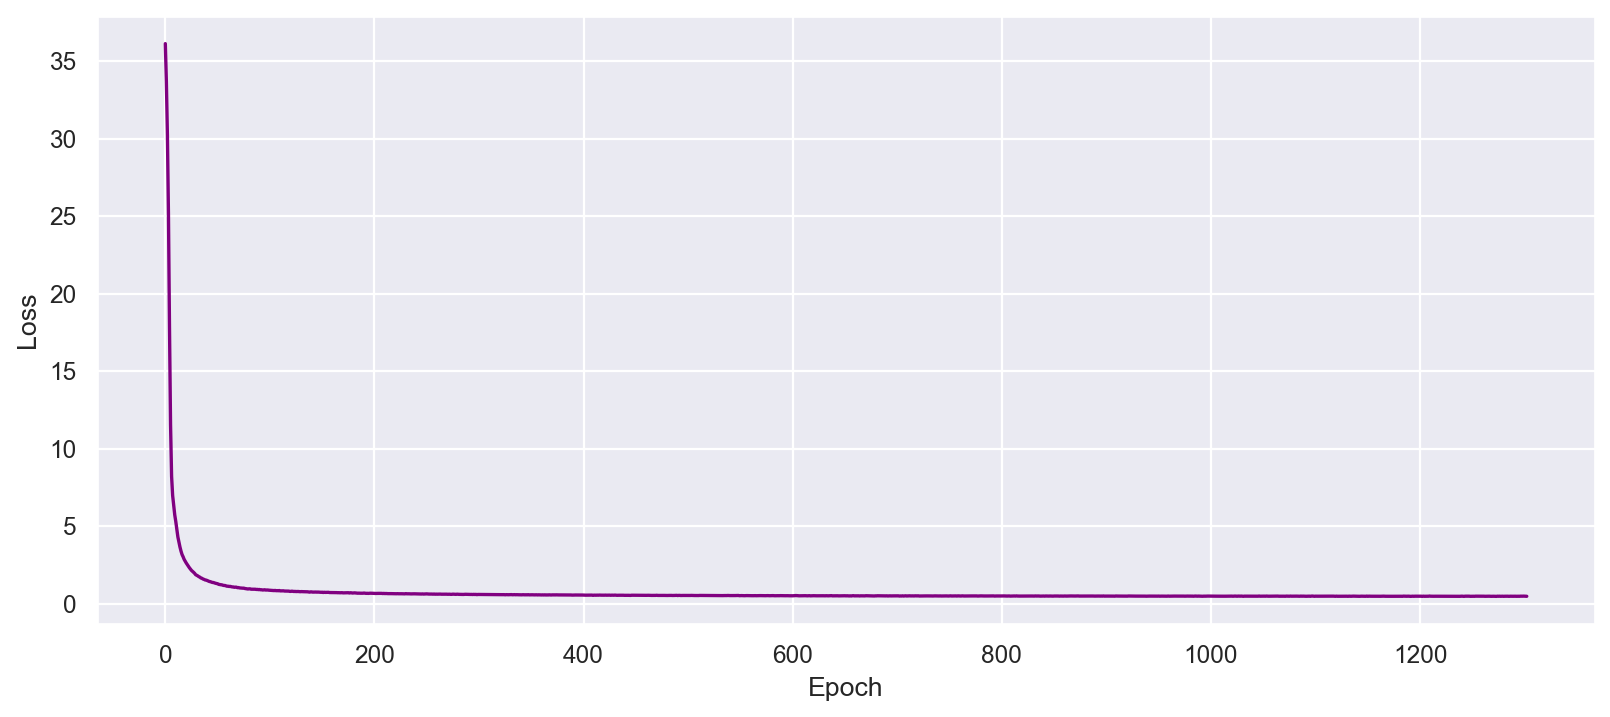

In [78]:
cmps.plot()

# Get Cell Embedding

normalizing counts per cell
    finished (0:00:00)


100%|██████████| 14039/14039 [01:13<00:00, 191.28it/s]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


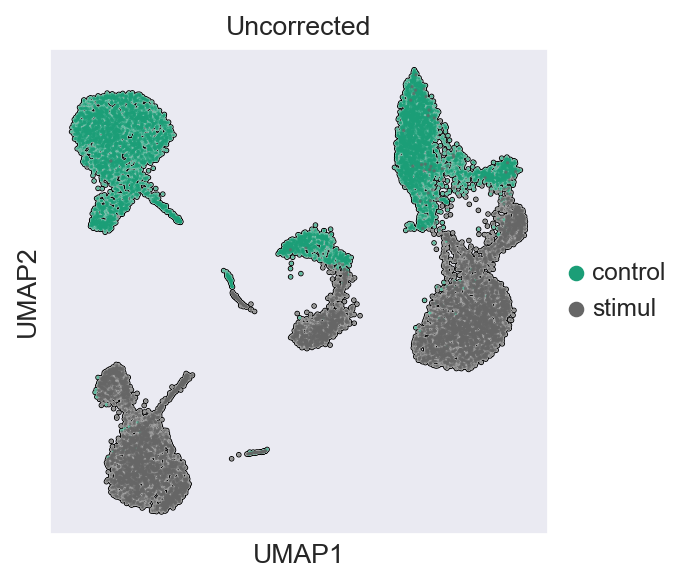

In [79]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
sc.pl.umap(adata,palette="Dark2",color=["sample"], title=["Uncorrected"], add_outline=True)

# Batch Correction

Generating batch vectors.
Computing correction vector for stimul.
Applying correction vectors.
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


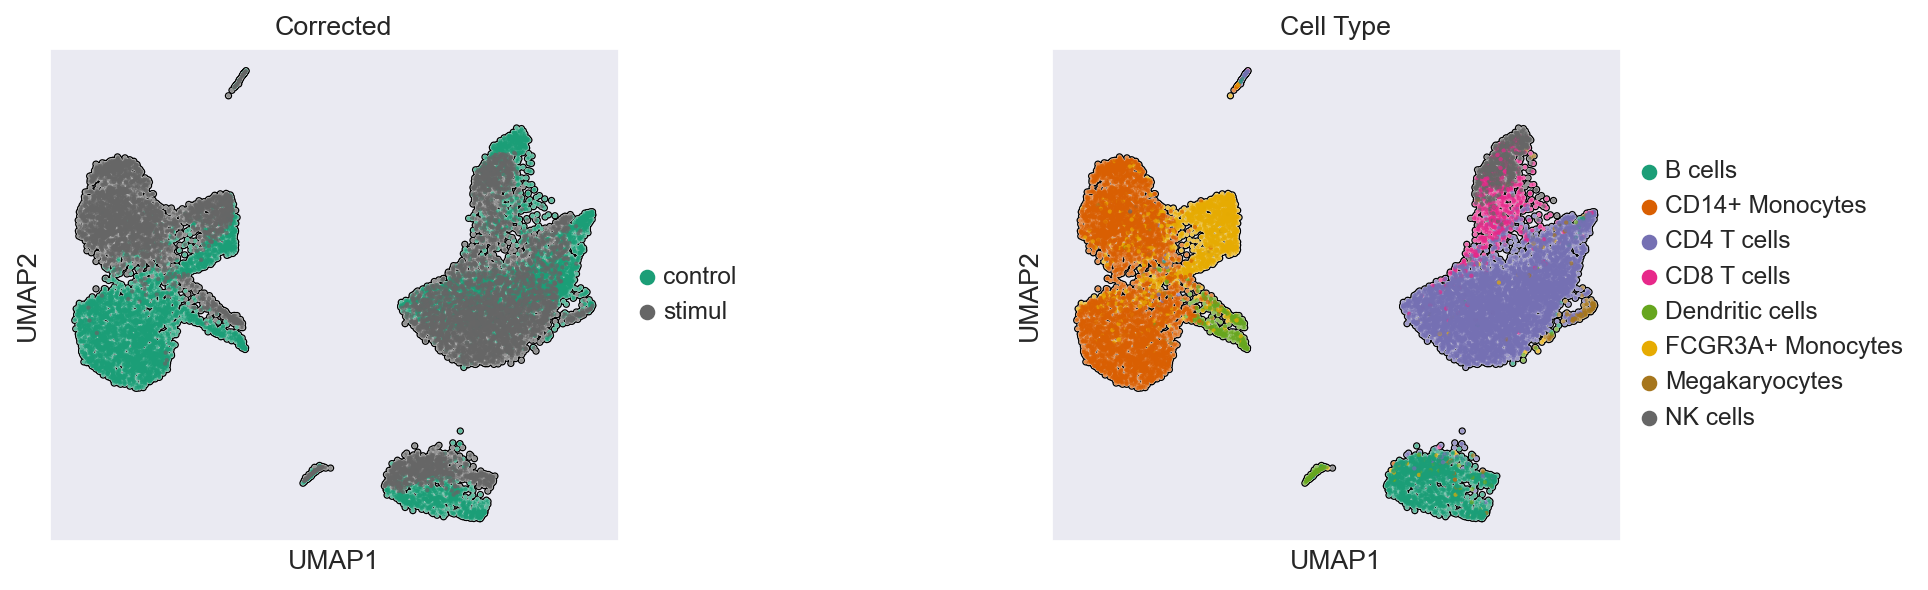

In [80]:
cembed.batch_correct(column="sample",reference="control")
adata = cembed.get_adata()
sc.pl.umap(adata,palette="Dark2",color=["sample","celltype"], wspace=0.6,
                                 title=["Corrected","Cell Type"],add_outline=True,size=15)

# Plot Gene Similarity

<AxesSubplot:xlabel='Similarity', ylabel='Gene'>

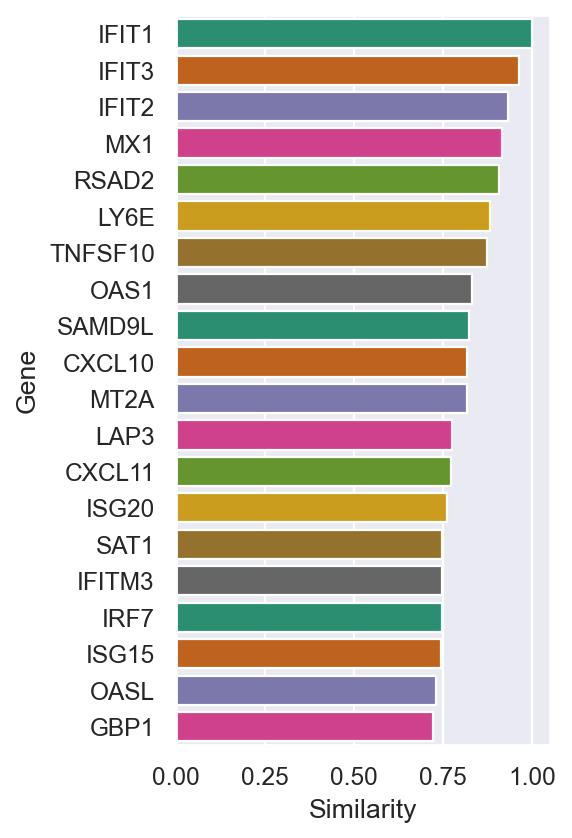

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
df = embed.compute_similarities("IFIT1").head(20)
fig,ax = plt.subplots(1,1,figsize=(3,6))
sns.barplot(data=df,y="Gene",x="Similarity",palette="Dark2",ax=ax)

      Gene  Similarity
0     CD8A    1.000000
1     CD8B    0.846971
2     GZMA    0.785145
3     GZMH    0.741225
4   FGFBP2    0.729278
5     CTSW    0.726546
6    TIGIT    0.719816
7     GZMK    0.709200
8     IL32    0.694482
9    KLRB1    0.676045
10    PRF1    0.674481
11   TRAT1    0.672479
12  GPR171    0.649857
13   KLRD1    0.635874
14    LAG3    0.620531
15    CD27    0.615600
16   CXCR3    0.591891
17   ITM2A    0.583674
18    PASK    0.574145
19  DNAJB1    0.554648


<AxesSubplot:xlabel='Similarity', ylabel='Gene'>

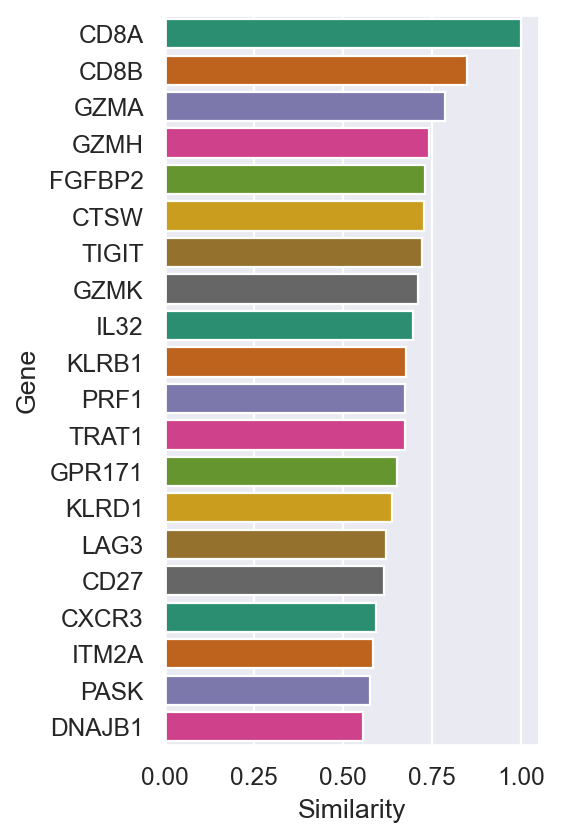

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.)
df = embed.compute_similarities("CD8A").head(20)
print(df)
fig,ax = plt.subplots(1,1,figsize=(3,6))
sns.barplot(data=df,y="Gene",x="Similarity",palette="Dark2",ax=ax)

# Get Gene Embedding

In [84]:
gdata = embed.get_adata()
metagenes = embed.get_metagenes(gdata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 147 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [85]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
embed.score_metagenes(adata, metagenes)

normalizing counts per cell
    finished (0:00:00)
computing score '48_SCORE'
    finished: added
    '48_SCORE', score of gene set (adata.obs).
    202 total control genes are used. (0:00:00)
computing score '12_SCORE'
    finished: added
    '12_SCORE', score of gene set (adata.obs).
    65 total control genes are used. (0:00:00)
computing score '9_SCORE'
    finished: added
    '9_SCORE', score of gene set (adata.obs).
    365 total control genes are used. (0:00:00)
computing score '131_SCORE'
    finished: added
    '131_SCORE', score of gene set (adata.obs).
    123 total control genes are used. (0:00:00)
computing score '100_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '100_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '134_SCORE'
    finished: added
    '134_SCORE', score of gene set (adata.obs).
    123 total control genes are used. (0:00:00)
computing score '64_SCORE'
    finished: added
    '64_SCORE', score of gene set (adata.obs).
    203 total control genes are used. (0:00:00)
computing score '11_SCORE'
    finished: added
    '11_SCORE', score of gene set (adata.obs).
    322 total control genes are used. (0:00:00)
computing score '141_SCORE'
    finished: added
    '141_SCORE', score of gene set (adata.obs).
    82 total control genes are used. (0:00:00)
computing score '10_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '10_SCORE', score of gene set (adata.obs).
    407 total control genes are used. (0:00:00)
computing score '41_SCORE'
    finished: added
    '41_SCORE', score of gene set (adata.obs).
    244 total control genes are used. (0:00:00)
computing score '14_SCORE'
    finished: added
    '14_SCORE', score of gene set (adata.obs).
    324 total control genes are used. (0:00:00)
computing score '71_SCORE'
    finished: added
    '71_SCORE', score of gene set (adata.obs).
    120 total control genes are used. (0:00:00)
computing score '35_SCORE'
    finished: added
    '35_SCORE', score of gene set (adata.obs).
    201 total control genes are used. (0:00:00)
computing score '43_SCORE'
    finished: added
    '43_SCORE', score of gene set (adata.obs).
    202 total control genes are used. (0:00:00)
computing score '70_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '70_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '79_SCORE'
    finished: added
    '79_SCORE', score of gene set (adata.obs).
    161 total control genes are used. (0:00:00)
computing score '66_SCORE'
    finished: added
    '66_SCORE', score of gene set (adata.obs).
    119 total control genes are used. (0:00:00)
computing score '72_SCORE'
    finished: added
    '72_SCORE', score of gene set (adata.obs).
    120 total control genes are used. (0:00:00)
computing score '34_SCORE'
    finished: added
    '34_SCORE', score of gene set (adata.obs).
    244 total control genes are used. (0:00:00)
computing score '69_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '69_SCORE', score of gene set (adata.obs).
    119 total control genes are used. (0:00:00)
computing score '39_SCORE'
    finished: added
    '39_SCORE', score of gene set (adata.obs).
    118 total control genes are used. (0:00:00)
computing score '40_SCORE'
    finished: added
    '40_SCORE', score of gene set (adata.obs).
    328 total control genes are used. (0:00:00)
computing score '119_SCORE'
    finished: added
    '119_SCORE', score of gene set (adata.obs).
    164 total control genes are used. (0:00:00)
computing score '38_SCORE'
    finished: added
    '38_SCORE', score of gene set (adata.obs).
    244 total control genes are used. (0:00:00)
computing score '90_SCORE'
    finished: added
    '90_SCORE', score of gene set (adata.obs).
    204 total control genes are used. (0:00:00)
computing score '25_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '25_SCORE', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score '28_SCORE'
    finished: added
    '28_SCORE', score of gene set (adata.obs).
    201 total control genes are used. (0:00:00)
computing score '18_SCORE'
    finished: added
    '18_SCORE', score of gene set (adata.obs).
    284 total control genes are used. (0:00:00)
computing score '76_SCORE'
    finished: added
    '76_SCORE', score of gene set (adata.obs).
    204 total control genes are used. (0:00:00)
computing score '20_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '20_SCORE', score of gene set (adata.obs).
    284 total control genes are used. (0:00:00)
computing score '2_SCORE'
    finished: added
    '2_SCORE', score of gene set (adata.obs).
    279 total control genes are used. (0:00:00)
computing score '5_SCORE'
    finished: added
    '5_SCORE', score of gene set (adata.obs).
    364 total control genes are used. (0:00:00)
computing score '145_SCORE'
    finished: added
    '145_SCORE', score of gene set (adata.obs).
    82 total control genes are used. (0:00:00)
computing score '47_SCORE'
    finished: added
    '47_SCORE', score of gene set (adata.obs).
    286 total control genes are used. (0:00:00)
computing score '118_SCORE'
    finished: added
    '118_SCORE', score of gene set (adata.obs).
    164 total control genes are used. (0:00:00)
computing score '82_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '82_SCORE', score of gene set (adata.obs).
    120 total control genes are used. (0:00:00)
computing score '109_SCORE'
    finished: added
    '109_SCORE', score of gene set (adata.obs).
    164 total control genes are used. (0:00:00)
computing score '77_SCORE'
    finished: added
    '77_SCORE', score of gene set (adata.obs).
    120 total control genes are used. (0:00:00)
computing score '29_SCORE'
    finished: added
    '29_SCORE', score of gene set (adata.obs).
    285 total control genes are used. (0:00:00)
computing score '3_SCORE'
    finished: added
    '3_SCORE', score of gene set (adata.obs).
    364 total control genes are used. (0:00:00)
computing score '36_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '36_SCORE', score of gene set (adata.obs).
    159 total control genes are used. (0:00:00)
computing score '94_SCORE'
    finished: added
    '94_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '143_SCORE'
    finished: added
    '143_SCORE', score of gene set (adata.obs).
    81 total control genes are used. (0:00:00)
computing score '60_SCORE'
    finished: added
    '60_SCORE', score of gene set (adata.obs).
    287 total control genes are used. (0:00:00)
computing score '21_SCORE'
    finished: added
    '21_SCORE', score of gene set (adata.obs).
    242 total control genes are used. (0:00:00)
computing score '0_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '0_SCORE', score of gene set (adata.obs).
    61 total control genes are used. (0:00:00)
computing score '50_SCORE'
    finished: added
    '50_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '117_SCORE'
    finished: added
    '117_SCORE', score of gene set (adata.obs).
    164 total control genes are used. (0:00:00)
computing score '91_SCORE'
    finished: added
    '91_SCORE', score of gene set (adata.obs).
    205 total control genes are used. (0:00:00)
computing score '1_SCORE'
    finished: added
    '1_SCORE', score of gene set (adata.obs).
    59 total control genes are used. (0:00:00)
computing score '42_SCORE'
    finished: added
    '42_SCORE', score of gene set (adata.obs).
    118 total control genes are used. (0:00:00)
computing score '103_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '103_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '98_SCORE'
    finished: added
    '98_SCORE', score of gene set (adata.obs).
    205 total control genes are used. (0:00:00)
computing score '93_SCORE'
    finished: added
    '93_SCORE', score of gene set (adata.obs).
    79 total control genes are used. (0:00:00)
computing score '45_SCORE'
    finished: added
    '45_SCORE', score of gene set (adata.obs).
    286 total control genes are used. (0:00:00)
computing score '110_SCORE'
    finished: added
    '110_SCORE', score of gene set (adata.obs).
    80 total control genes are used. (0:00:00)
computing score '24_SCORE'
    finished: added
    '24_SCORE', score of gene set (adata.obs).
    243 total control genes are used. (0:00:00)
computing score '85_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '85_SCORE', score of gene set (adata.obs).
    121 total control genes are used. (0:00:00)
computing score '97_SCORE'
    finished: added
    '97_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '8_SCORE'
    finished: added
    '8_SCORE', score of gene set (adata.obs).
    113 total control genes are used. (0:00:00)
computing score '51_SCORE'
    finished: added
    '51_SCORE', score of gene set (adata.obs).
    244 total control genes are used. (0:00:00)
computing score '16_SCORE'
    finished: added
    '16_SCORE', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score '104_SCORE'
    finished: added
    '104_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '4_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '4_SCORE', score of gene set (adata.obs).
    406 total control genes are used. (0:00:00)
computing score '129_SCORE'
    finished: added
    '129_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '101_SCORE'
    finished: added
    '101_SCORE', score of gene set (adata.obs).
    162 total control genes are used. (0:00:00)
computing score '56_SCORE'
    finished: added
    '56_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '80_SCORE'
    finished: added
    '80_SCORE', score of gene set (adata.obs).
    205 total control genes are used. (0:00:00)
computing score '92_SCORE'
    finished: added
    '92_SCORE', score of gene set (adata.obs).
    205 total control genes are used. (0:00:00)
computing score '63_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '63_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '107_SCORE'
    finished: added
    '107_SCORE', score of gene set (adata.obs).
    80 total control genes are used. (0:00:00)
computing score '26_SCORE'
    finished: added
    '26_SCORE', score of gene set (adata.obs).
    244 total control genes are used. (0:00:00)
computing score '68_SCORE'
    finished: added
    '68_SCORE', score of gene set (adata.obs).
    161 total control genes are used. (0:00:00)
computing score '6_SCORE'
    finished: added
    '6_SCORE', score of gene set (adata.obs).
    63 total control genes are used. (0:00:00)
computing score '19_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '19_SCORE', score of gene set (adata.obs).
    284 total control genes are used. (0:00:00)
computing score '83_SCORE'
    finished: added
    '83_SCORE', score of gene set (adata.obs).
    204 total control genes are used. (0:00:00)
computing score '127_SCORE'
    finished: added
    '127_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '67_SCORE'
    finished: added
    '67_SCORE', score of gene set (adata.obs).
    161 total control genes are used. (0:00:00)
computing score '123_SCORE'
    finished: added
    '123_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '122_SCORE'
    finished: added
    '122_SCORE', score of gene set (adata.obs).
    164 total control genes are used. (0:00:00)
computing score '106_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '106_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '17_SCORE'
    finished: added
    '17_SCORE', score of gene set (adata.obs).
    157 total control genes are used. (0:00:00)
computing score '59_SCORE'
    finished: added
    '59_SCORE', score of gene set (adata.obs).
    203 total control genes are used. (0:00:00)
computing score '49_SCORE'
    finished: added
    '49_SCORE', score of gene set (adata.obs).
    202 total control genes are used. (0:00:00)
computing score '52_SCORE'
    finished: added
    '52_SCORE', score of gene set (adata.obs).
    161 total control genes are used. (0:00:00)
computing score '108_SCORE'
    finished: added
    '108_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '55_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '55_SCORE', score of gene set (adata.obs).
    161 total control genes are used. (0:00:00)
computing score '33_SCORE'
    finished: added
    '33_SCORE', score of gene set (adata.obs).
    75 total control genes are used. (0:00:00)
computing score '32_SCORE'
    finished: added
    '32_SCORE', score of gene set (adata.obs).
    242 total control genes are used. (0:00:00)
computing score '74_SCORE'
    finished: added
    '74_SCORE', score of gene set (adata.obs).
    162 total control genes are used. (0:00:00)
computing score '99_SCORE'
    finished: added
    '99_SCORE', score of gene set (adata.obs).
    205 total control genes are used. (0:00:00)
computing score '96_SCORE'
    finished: added
    '96_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '142_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '142_SCORE', score of gene set (adata.obs).
    82 total control genes are used. (0:00:00)
computing score '81_SCORE'
    finished: added
    '81_SCORE', score of gene set (adata.obs).
    205 total control genes are used. (0:00:00)
computing score '138_SCORE'
    finished: added
    '138_SCORE', score of gene set (adata.obs).
    123 total control genes are used. (0:00:00)
computing score '62_SCORE'
    finished: added
    '62_SCORE', score of gene set (adata.obs).
    203 total control genes are used. (0:00:00)
computing score '15_SCORE'
    finished: added
    '15_SCORE', score of gene set (adata.obs).
    284 total control genes are used. (0:00:00)
computing score '132_SCORE'
    finished: added
    '132_SCORE', score of gene set (adata.obs).
    123 total control genes are used. (0:00:00)
computing score '73_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/n

    finished: added
    '73_SCORE', score of gene set (adata.obs).
    162 total control genes are used. (0:00:00)
computing score '27_SCORE'
    finished: added
    '27_SCORE', score of gene set (adata.obs).
    159 total control genes are used. (0:00:00)
computing score '54_SCORE'
    finished: added
    '54_SCORE', score of gene set (adata.obs).
    203 total control genes are used. (0:00:00)
computing score '88_SCORE'
    finished: added
    '88_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '111_SCORE'
    finished: added
    '111_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '57_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarni

    finished: added
    '57_SCORE', score of gene set (adata.obs).
    161 total control genes are used. (0:00:00)
computing score '61_SCORE'
    finished: added
    '61_SCORE', score of gene set (adata.obs).
    203 total control genes are used. (0:00:00)
computing score '44_SCORE'
    finished: added
    '44_SCORE', score of gene set (adata.obs).
    286 total control genes are used. (0:00:00)
computing score '133_SCORE'
    finished: added
    '133_SCORE', score of gene set (adata.obs).
    123 total control genes are used. (0:00:00)
computing score '86_SCORE'
    finished: added
    '86_SCORE', score of gene set (adata.obs).
    121 total control genes are used. (0:00:00)
computing score '139_SCORE'
    finished: added
    '139_SCORE', score of gene set (adata.obs).
    82 total control genes are used. (0:00:00)
computing score '65_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

    finished: added
    '65_SCORE', score of gene set (adata.obs).
    161 total control genes are used. (0:00:00)
computing score '31_SCORE'
    finished: added
    '31_SCORE', score of gene set (adata.obs).
    285 total control genes are used. (0:00:00)
computing score '46_SCORE'
    finished: added
    '46_SCORE', score of gene set (adata.obs).
    285 total control genes are used. (0:00:00)
computing score '22_SCORE'
    finished: added
    '22_SCORE', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score '120_SCORE'
    finished: added
    '120_SCORE', score of gene set (adata.obs).
    115 total control genes are used. (0:00:00)
computing score '126_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarni

    finished: added
    '126_SCORE', score of gene set (adata.obs).
    121 total control genes are used. (0:00:00)
computing score '7_SCORE'
    finished: added
    '7_SCORE', score of gene set (adata.obs).
    365 total control genes are used. (0:00:00)
computing score '23_SCORE'
    finished: added
    '23_SCORE', score of gene set (adata.obs).
    325 total control genes are used. (0:00:00)
computing score '125_SCORE'
    finished: added
    '125_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '37_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarni

    finished: added
    '37_SCORE', score of gene set (adata.obs).
    159 total control genes are used. (0:00:00)
computing score '78_SCORE'
    finished: added
    '78_SCORE', score of gene set (adata.obs).
    162 total control genes are used. (0:00:00)
computing score '121_SCORE'
    finished: added
    '121_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '84_SCORE'
    finished: added
    '84_SCORE', score of gene set (adata.obs).
    205 total control genes are used. (0:00:00)
computing score '102_SCORE'
    finished: added
    '102_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '135_SCORE'
    finished: added
    '135_SCORE', score of gene set (adata.obs).
    123 total control genes are used. (0:00:00)
computing score '58_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

    finished: added
    '58_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '115_SCORE'
    finished: added
    '115_SCORE', score of gene set (adata.obs).
    164 total control genes are used. (0:00:00)
computing score '30_SCORE'
    finished: added
    '30_SCORE', score of gene set (adata.obs).
    152 total control genes are used. (0:00:00)
computing score '130_SCORE'
    finished: added
    '130_SCORE', score of gene set (adata.obs).
    123 total control genes are used. (0:00:00)
computing score '87_SCORE'
    finished: added
    '87_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '13_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarni

    finished: added
    '13_SCORE', score of gene set (adata.obs).
    283 total control genes are used. (0:00:00)
computing score '95_SCORE'
    finished: added
    '95_SCORE', score of gene set (adata.obs).
    121 total control genes are used. (0:00:00)
computing score '89_SCORE'
    finished: added
    '89_SCORE', score of gene set (adata.obs).
    163 total control genes are used. (0:00:00)
computing score '140_SCORE'
    finished: added
    '140_SCORE', score of gene set (adata.obs).
    82 total control genes are used. (0:00:00)
computing score '114_SCORE'
    finished: added
    '114_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '112_SCORE'
    finished: added
    '112_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '124_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

    finished: added
    '124_SCORE', score of gene set (adata.obs).
    164 total control genes are used. (0:00:00)
computing score '116_SCORE'
    finished: added
    '116_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '128_SCORE'
    finished: added
    '128_SCORE', score of gene set (adata.obs).
    81 total control genes are used. (0:00:00)
computing score '75_SCORE'
    finished: added
    '75_SCORE', score of gene set (adata.obs).
    120 total control genes are used. (0:00:00)
computing score '53_SCORE'
    finished: added
    '53_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '146_SCORE'


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarni

    finished: added
    '146_SCORE', score of gene set (adata.obs).
    41 total control genes are used. (0:00:00)
computing score '137_SCORE'
    finished: added
    '137_SCORE', score of gene set (adata.obs).
    123 total control genes are used. (0:00:00)
computing score '105_SCORE'
    finished: added
    '105_SCORE', score of gene set (adata.obs).
    122 total control genes are used. (0:00:00)
computing score '113_SCORE'
    finished: added
    '113_SCORE', score of gene set (adata.obs).
    121 total control genes are used. (0:00:00)
computing score '136_SCORE'
    finished: added
    '136_SCORE', score of gene set (adata.obs).
    123 total control genes are used. (0:00:00)
computing score '144_SCORE'
    finished: added
    '144_SCORE', score of gene set (adata.obs).
    40 total control genes are used. (0:00:00)


/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/nceglia/miniconda/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

# Find Interferon Metagene

6 ['RSAD2', 'TNFSF10', 'CXCL10', 'LY6E', 'IFIT2', 'IFIT3', 'IFIT1', 'IFITM3', 'IRF7', 'OAS1', 'ISG20', 'CCL8', 'APOBEC3A', 'MX1']


/Users/nceglia/miniconda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


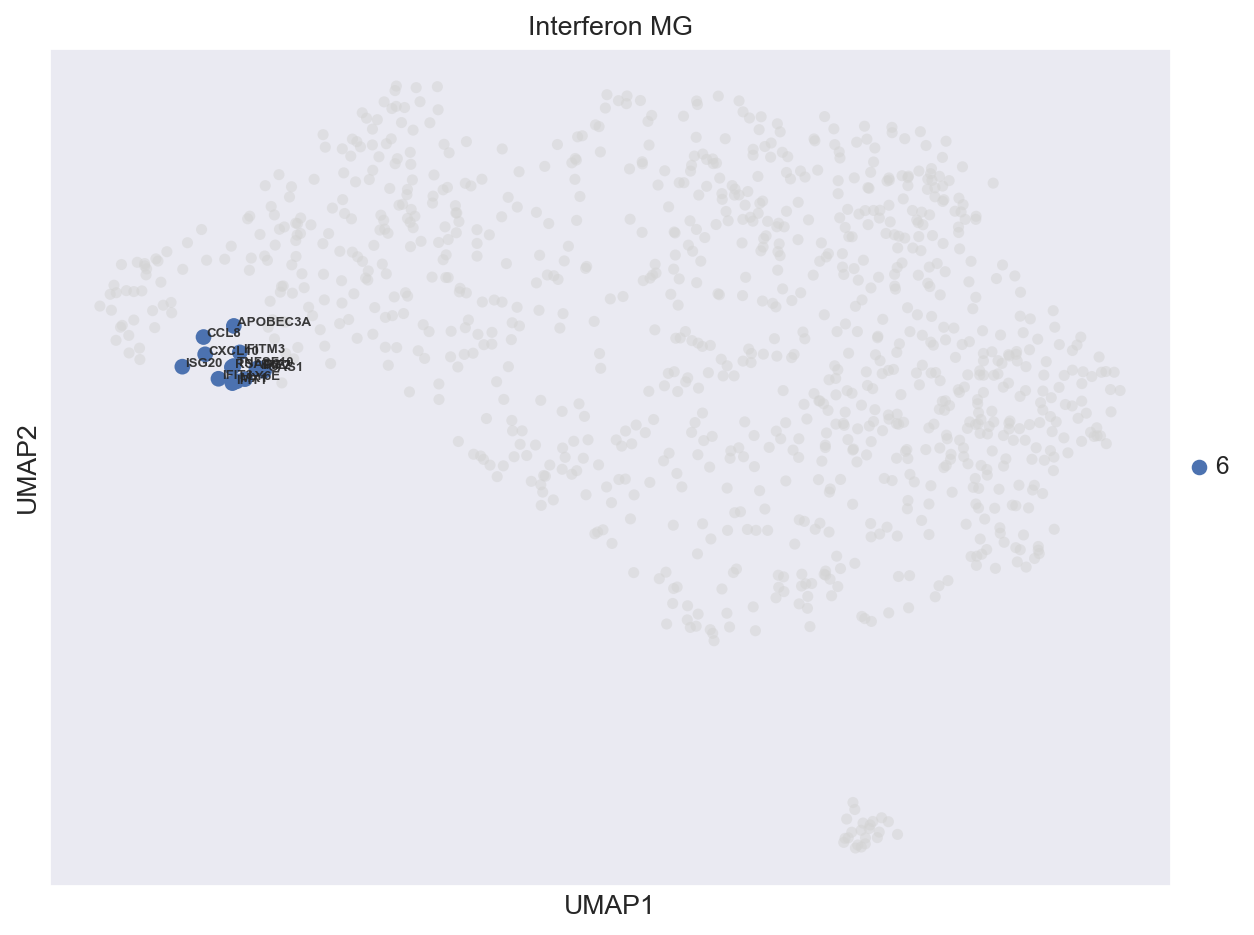

In [86]:
for clust, genes in metagenes.items():
    if "IFIT1" in genes:
        print(clust,genes)
        embed.plot_metagene(gdata, mg=clust, title="Interferon MG")
        break

# Find Markers of Cell Type and Batch

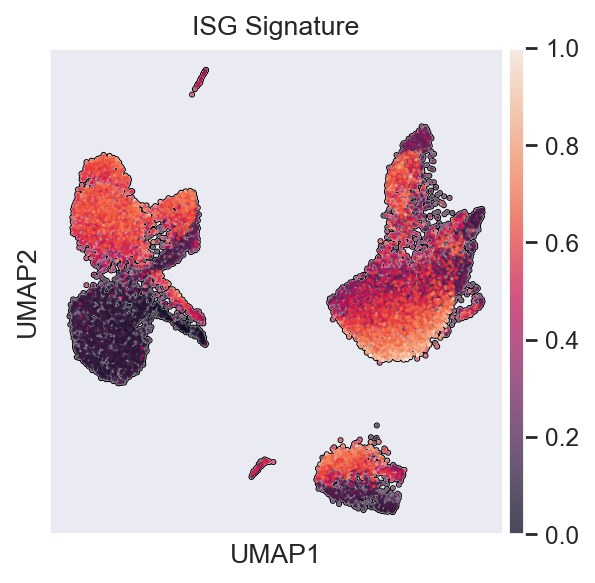

In [87]:
sc.pl.umap(adata,color=["{}_SCORE".format(clust)],
           add_outline=True,title="ISG Signature",size=10)

# Annotate Cell Types with Pseudo-probabilities

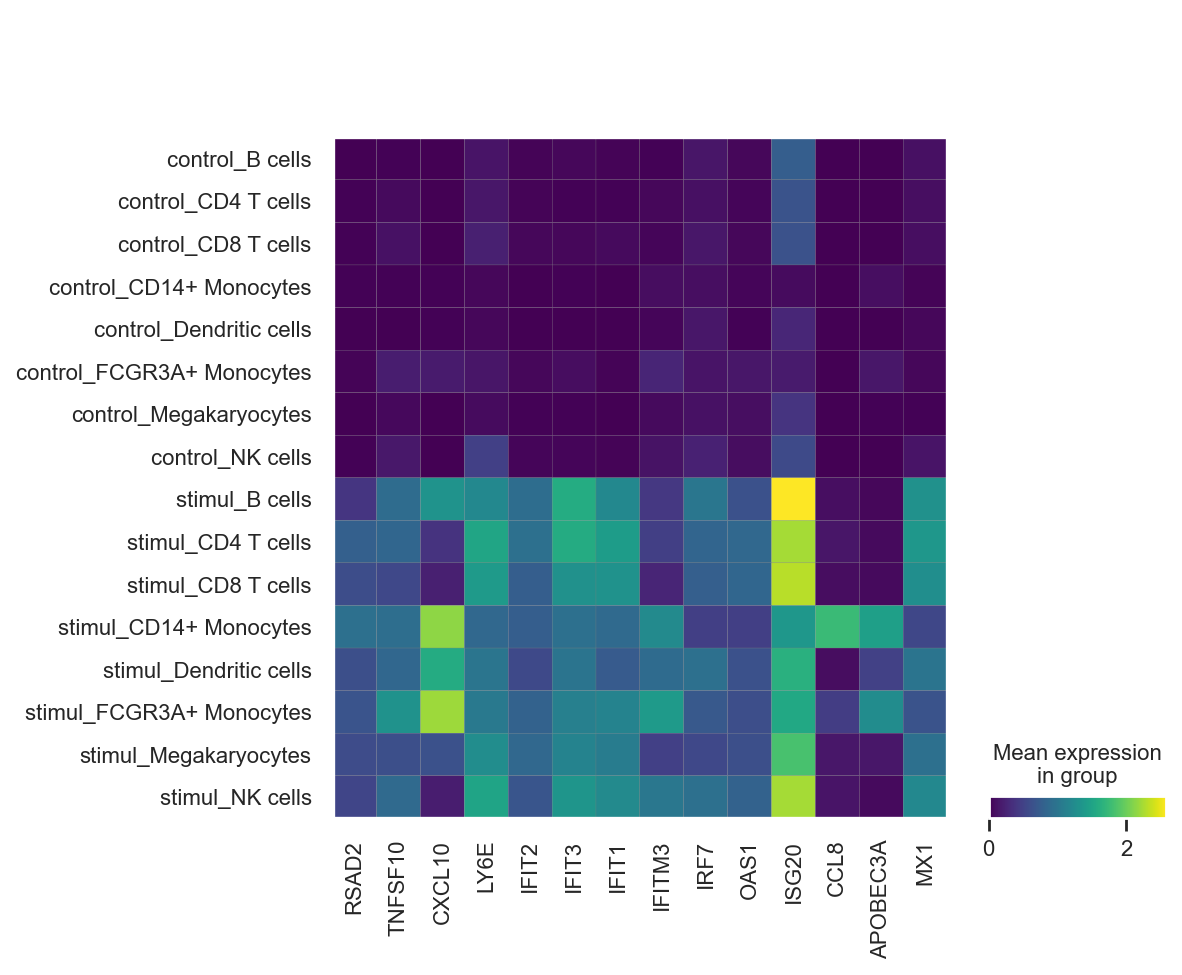

In [88]:
genes = [x for x in genes if x in adata.var.index.tolist()]
sc.pl.matrixplot(adata,genes,groupby="detailed_celltype")

# Plot All Metagenes

<Figure size 400x1040 with 0 Axes>

<Figure size 320x320 with 0 Axes>

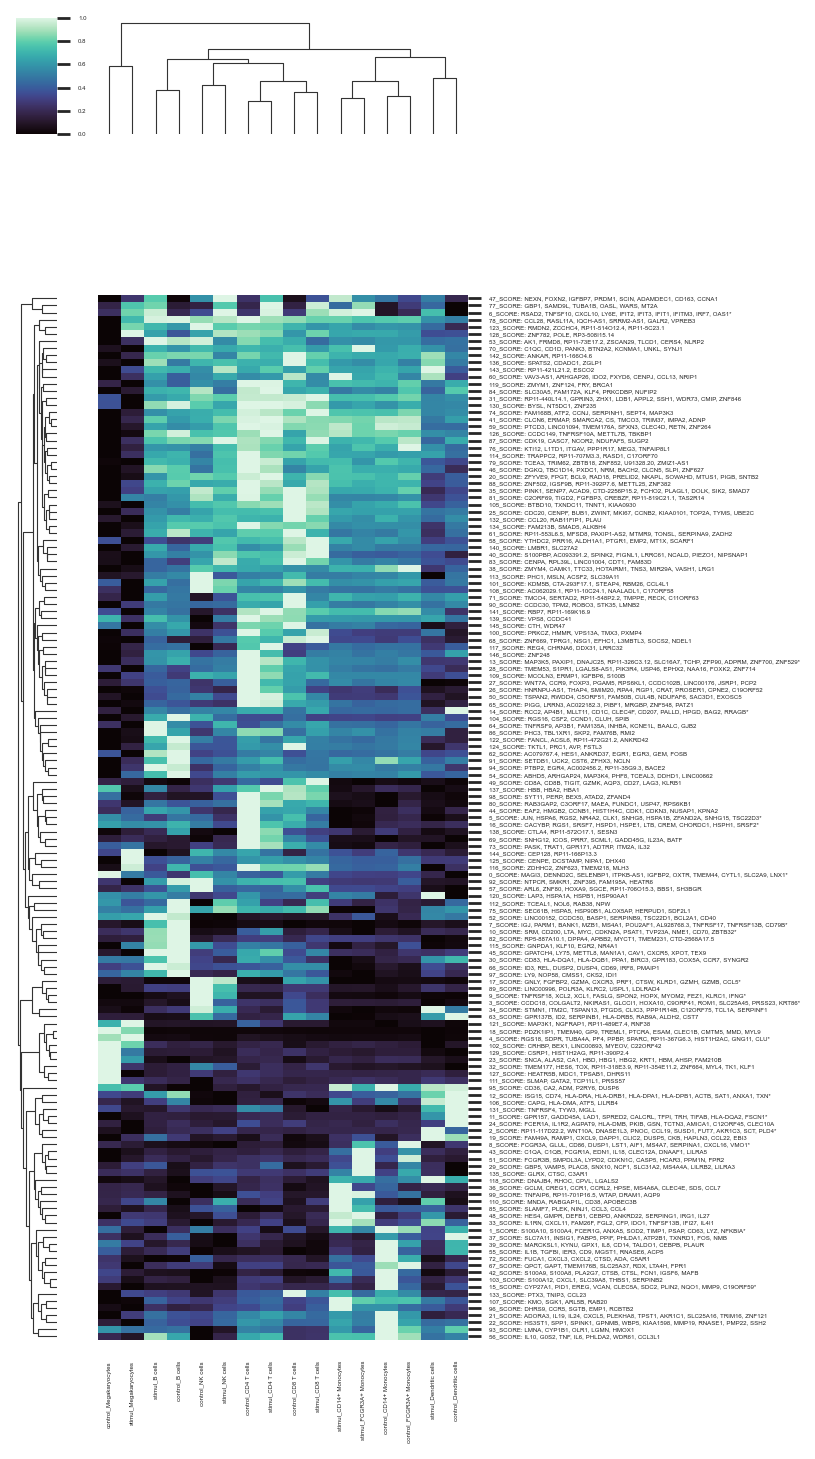

In [89]:
sns.set(font_scale=0.25)
embed.plot_metagenes_scores(adata,metagenes,"detailed_celltype")

# Find Similar Genes to Cell Type

In [94]:
import pandas
markers = cembed.get_predictive_genes(adata,"celltype",n_genes=15)
pandas.DataFrame.from_dict(markers).T

0              1         2         3        4   \
CD14+ Monocytes          RETN         FCER1G    SPINK1      SOD2    ANXA5   
Dendritic cells      HLA-DRB1       HLA-DPA1      CST3  HLA-DQB1  HLA-DRA   
CD4 T cells              ICOS          NAA16      PASK     LRRN3   ZNF529   
CD8 T cells              GZMA          KLRD1      CTSW     KLRC1     PRF1   
Megakaryocytes         TMEM40            GP9     ACRBP       PF4     NRGN   
B cells            AC006129.4          CXCR5      KLK1   POU2AF1    CD200   
FCGR3A+ Monocytes    TMEM176B  RP11-290F20.3  SERPINA1       CFD     RETN   
NK cells                KLRC1           PRF1      XCL2      CTSW    KLRD1   

                         5         6         7         8        9        10  \
CD14+ Monocytes      LGALS3     PLAUR    TYROBP  TMEM176B   PHLDA2   PLA2G7   
Dendritic cells    HLA-DPB1  HLA-DQA1      KYNU       LYZ  HLA-DMA    ALDH2   
CD4 T cells           S100B      NSG1     TRAT1   TBL1XR1   SNHG12  SLC16A7   
CD8 T cells            XCL2     FASLG      GZMH      XCL1     HOPX   FGFBP2   
Megakaryocytes        TUBB1     GNG11      SDPR      PPBP   TREML1    SPARC   
B cells               MS4A1  HLA-DPA1  HLA-DQA1      CD83      LY9     CD70   
FCGR3A+ Monocytes    FCER1G      AIF1      IL18     C3AR1  CLEC12A     LST1   
NK cells               XCL1      NKG7      GNLY     KRT81     HOPX    FASLG   

                       11            12        13         14  
CD14+ Monocytes    RCBTB2          MAFB  C15ORF48      IGSF6  
Dendritic cells     ANXA2           TXN     CLIC2     LGALS1  
CD4 T cells          HPS4          REG4    CHRNA6      EPHX2  
CD8 T cells          IFNG          NKG7     KLRB1       GZMK  
Megakaryocytes     CLEC1B  RP11-367G6.3       CLU      CMTM5  
B cells              XPOT      HLA-DQB1      IRF8  TNFRSF13B  
FCGR3A+ Monocytes  TYROBP        CXCL16     PLAUR       KYNU  
NK cells             GZMH         SPON2      GZMA     FGFBP2

In [91]:
adata = cembed.phenotype_probability(adata,markers,dict())

100%|██████████| 14039/14039 [00:00<00:00, 61830.29it/s]
/Users/nceglia/miniconda/lib/python3.9/site-packages/genevector-0.0.1-py3.9.egg/genevector/embedding.py:476: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


CD14+ Monocytes
Dendritic cells
CD4 T cells
CD8 T cells
Megakaryocytes
B cells
FCGR3A+ Monocytes
NK cells


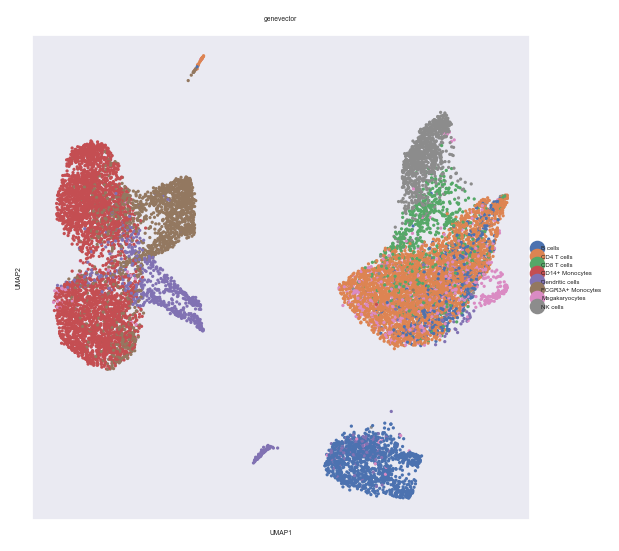

In [92]:
sc.pl.umap(adata,color="genevector")

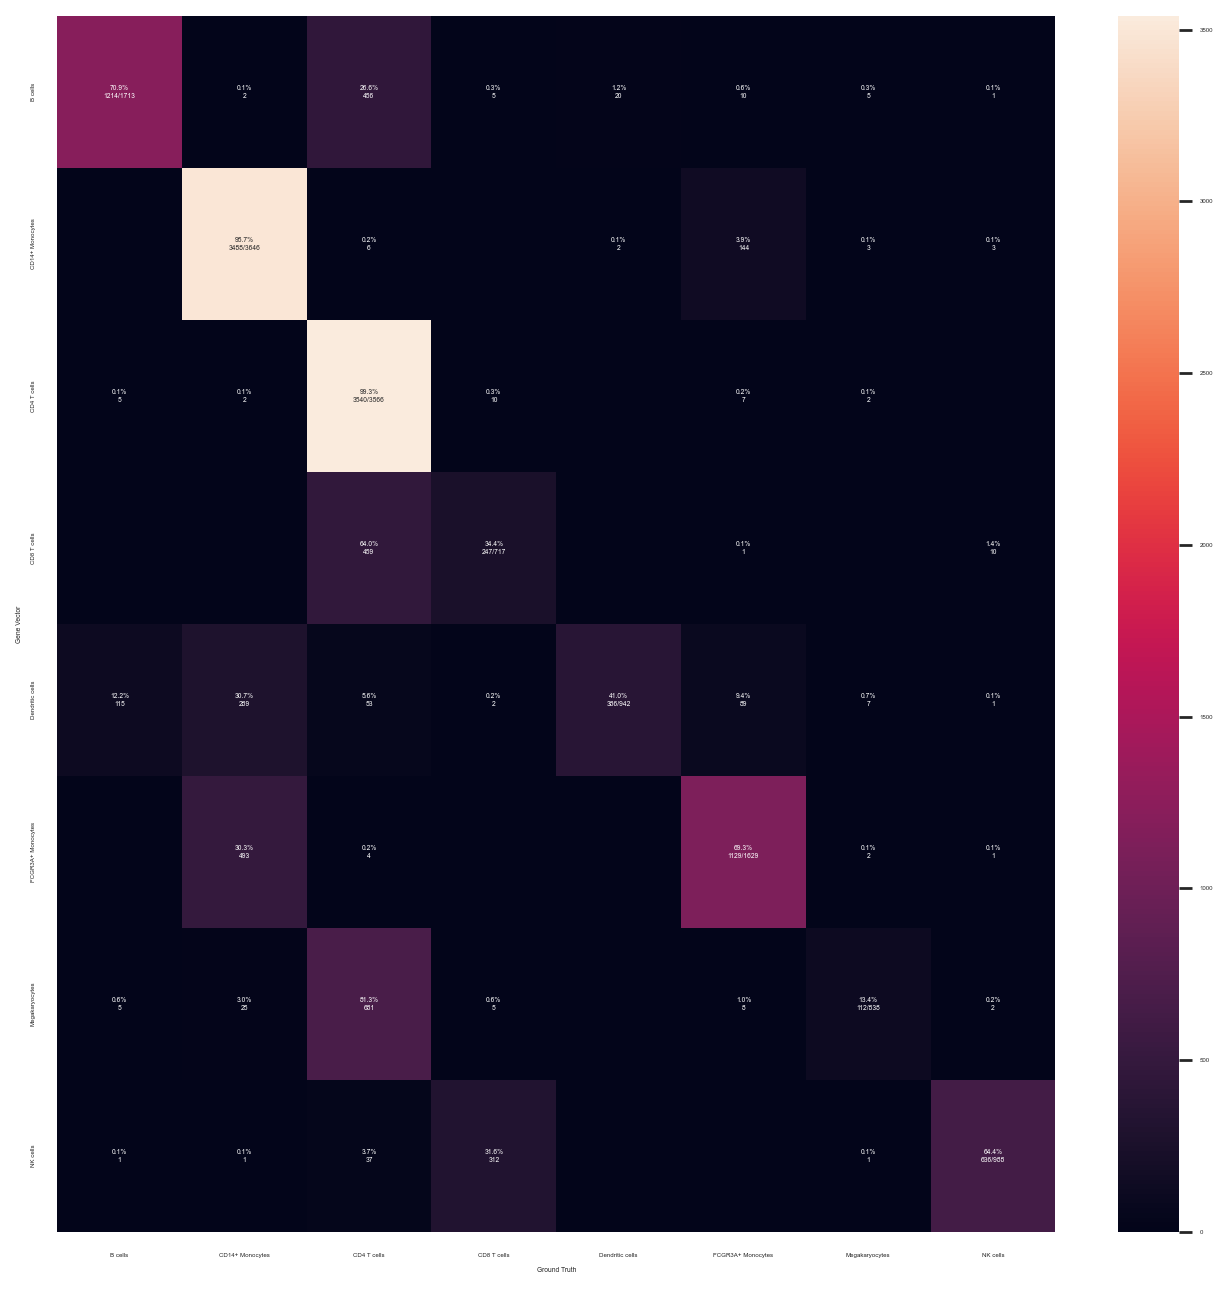

In [93]:
cembed.plot_confusion_matrix(adata,"genevector","celltype")

In [95]:
tdata = adata.copy()
gdata = tdata.T
sc.tl.pca(gdata,n_comps=100)

import tqdm
pcaembed = GeneEmbedding("pbmc.vec", dataset, vector="average")

pcaembed.embeddings
nembeddings = dict()
for gene, component in zip(tdata.var.index,gdata.obsm["X_pca"]):
    c = list(component)
    nembeddings[gene] = c
pcaembed.embeddings = nembeddings

pcaembed.vector = []
pcaembed.genes = []

for gene in tqdm.tqdm(pcaembed.embeddings.keys()):
    pcaembed.vector.append(pcaembed.embeddings[gene])
    pcaembed.genes.append(gene)


computing PCA
    with n_comps=100
    finished (0:00:00)
Loading average of 1st and 2nd weights.


100%|██████████| 1000/1000 [00:00<00:00, 2212185.65it/s]


In [99]:
pcag = pcaembed.compute_similarities("IFIT1")[:50]["Gene"]
g = embed.compute_similarities("IFIT1")[:50]["Gene"]
set(pcag).intersection(g)
set(pcag).difference(g)
# set(g).difference(pcag)

{'CCR7',
 'CREM',
 'FTH1',
 'GBP5',
 'HSPA1A',
 'IL1RN',
 'LTB',
 'NEXN',
 'NFKBIA',
 'PLAC8',
 'SEC61B',
 'TXN'}

In [100]:

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import operator

embedding = gdata.obsm["X_pca"]
distances = dict()
targets = gdata.obs.index.tolist()
tembed = embedding[gdata.obs.index.tolist().index("IFIT1")]
for target in targets:
    v = embedding[gdata.obs.index.tolist().index(target)]
    distance = float(cosine_similarity(numpy.array(tembed).reshape(1, -1),numpy.array(v).reshape(1, -1))[0])
    distances[target] = distance
sorted_distances = list(reversed(sorted(distances.items(), key=operator.itemgetter(1))))
genes = [x[0] for x in sorted_distances]
distance = [x[1] for x in sorted_distances]
df = pandas.DataFrame.from_dict({"Gene":genes, "Similarity":distance})

In [101]:
df.head(20)

Gene  Similarity
0      IFIT1    1.000000
1      ISG15    0.835303
2      IFIT3    0.829870
3      ISG20    0.804109
4       LY6E    0.784036
5        MX1    0.771492
6      IFIT2    0.734302
7    TNFSF10    0.702081
8       OAS1    0.680012
9      RSAD2    0.665307
10      IRF7    0.651354
11      MT2A    0.617326
12      SAT1    0.615557
13  TNFSF13B    0.592921
14      GBP1    0.586291
15    IFITM3    0.576767
16      GBP5    0.559789
17      OASL    0.551101
18    CXCL10    0.523523
19  RABGAP1L    0.518571

In [49]:
import collections
import numpy
from sklearn.metrics.pairwise import cosine_similarity
import tqdm
embedding = gdata.obsm["X_pca"]
distances = collections.defaultdict(dict)
targets = gdata.obs.index.tolist()
for mtarget in tqdm.tqdm(targets):
    tembed = embedding[gdata.obs.index.tolist().index(mtarget)]
    for target in targets:
        v = embedding[gdata.obs.index.tolist().index(target)]
        distance = float(cosine_similarity(numpy.array(tembed).reshape(1, -1),numpy.array(v).reshape(1, -1))[0])
        distances[mtarget][target] = distance

100%|██████████| 1000/1000 [01:53<00:00,  8.82it/s]


In [50]:
targets = list(embed.embeddings.keys())
gdistances = collections.defaultdict(dict)
for gene in gdata.obs.index.tolist():
    if gene not in embed.embeddings:
        continue
    embedding = embed.embeddings[gene]
    for target in targets:
        if target not in embed.embeddings:
            continue
        v = embed.embeddings[target]
        distance = float(cosine_similarity(numpy.array(embedding).reshape(1, -1),numpy.array(v).reshape(1, -1))[0])
        gdistances[gene][target] = distance

In [51]:
x = []
y = []
genes = []
dgenes = []
for gene, targets in gdistances.items():
    for target, sim in targets.items():
        if gene in distances and target in distances[gene]:
            genes.append(gene)
            dgenes.append(target)
            x.append(sim)
            y.append(distances[gene][target])
df = pandas.DataFrame.from_dict({"Gene":genes,"Target":dgenes,"g_sim":x,"p_sim":y})
df

Gene    Target     g_sim     p_sim
0        HES4      HES4  1.000000  1.000000
1        HES4     ISG15  0.470842  0.302106
2        HES4  TNFRSF18  0.361545 -0.100939
3        HES4   TNFRSF4  0.338721 -0.098352
4        HES4     PRKCZ  0.036205  0.004190
...       ...       ...       ...       ...
974164  S100B    SH3BGR  0.332065  0.777653
974165  S100B     BACE2  0.158802  0.745896
974166  S100B       MX1  0.162841 -0.431313
974167  S100B      CSTB  0.142575 -0.337555
974168  S100B     S100B  1.000000  1.000000

[974169 rows x 4 columns]

In [52]:
df = df[df["Gene"]!=df["Target"]]
df["diff"] = numpy.abs(df["g_sim"] - df["p_sim"])

/var/folders/5k/rhppjv2j7wb36wb6v0lxxb1c0000gn/T/ipykernel_13138/2326454826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff"] = numpy.abs(df["g_sim"] - df["p_sim"])


In [65]:
df[df["diff"]>1.4].sort_values("p_sim")

Gene         Target     g_sim     p_sim      diff
185177         TMPPE           FTH1  0.489662 -0.923257  1.412919
600283          FTH1          TMPPE  0.489662 -0.923257  1.412919
376655  RP11-390P2.4           FTH1  0.523402 -0.923122  1.446524
600477          FTH1   RP11-390P2.4  0.523402 -0.923122  1.446524
600661          FTH1  RP11-472G21.2  0.499512 -0.922822  1.422333
...              ...            ...       ...       ...       ...
584693        PHLDA2           ACTB  0.596406 -0.817901  1.414307
241746         APBB2         ZNF625 -0.408428  0.996569  1.404997
906310        ZNF625          APBB2 -0.408428  0.996569  1.404997
906529        ZNF625      LINC00893 -0.417547  0.997494  1.415041
457899     LINC00893         ZNF625 -0.417547  0.997494  1.415041

[108 rows x 5 columns]

In [72]:
from scipy.stats import pearsonr
def plot_coexpression(gene1, gene2, adata, mi_scores, gsim, psim):
    prof1 = adata.X[:,adata.var.index.tolist().index(gene1)]
    prof2 = adata.X[:,adata.var.index.tolist().index(gene2)]
    fig,ax = plt.subplots(1,5,figsize=(16,4))
    sc.pl.umap(adata, color=[gene1], ax=ax[0], size=50, show=False)
    sc.pl.umap(adata, color=[gene2], ax=ax[1], size=50, show=False)
    sns.scatterplot(prof1,prof2,ax=ax[2])
    mi = mi_scores[gene1][gene2]
    r2 = pearsonr(prof1,prof2)
    sns.barplot(x=["MI","r2"],y=[mi,r2.statistic],ax=ax[3])
    sns.barplot(x=["GV Sim","PCA Sim"],y=[gsim,psim],ax=ax[4])
    plt.tight_layout()

In [69]:
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)
# sc.tl.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

/Users/nceglia/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/nceglia/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/nceglia/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

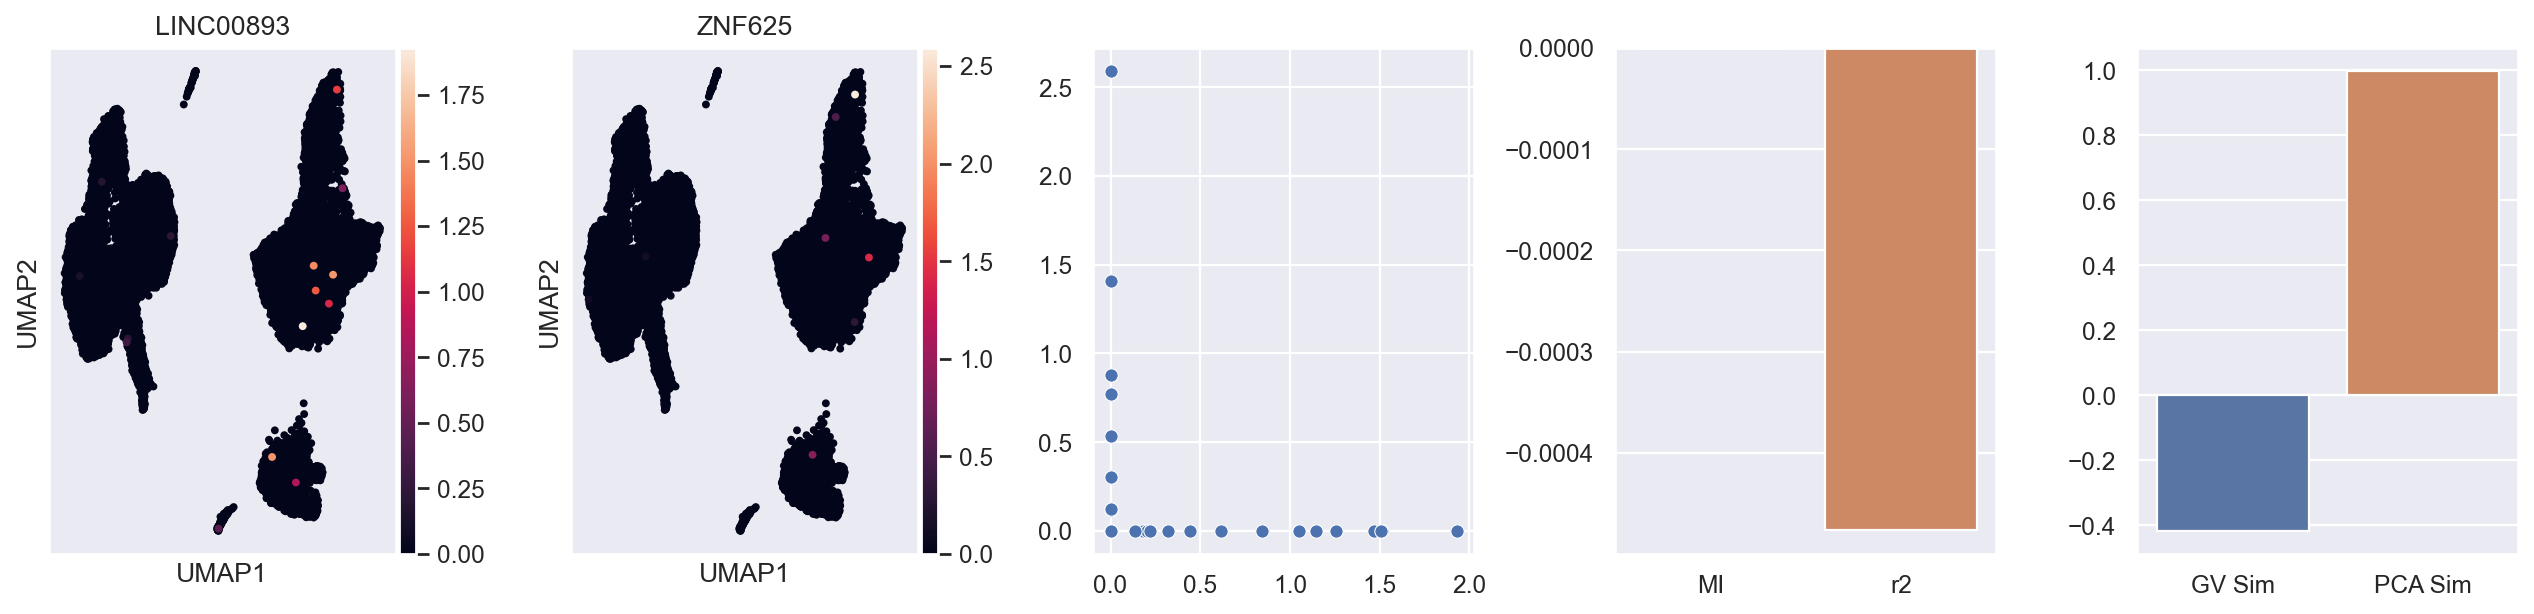

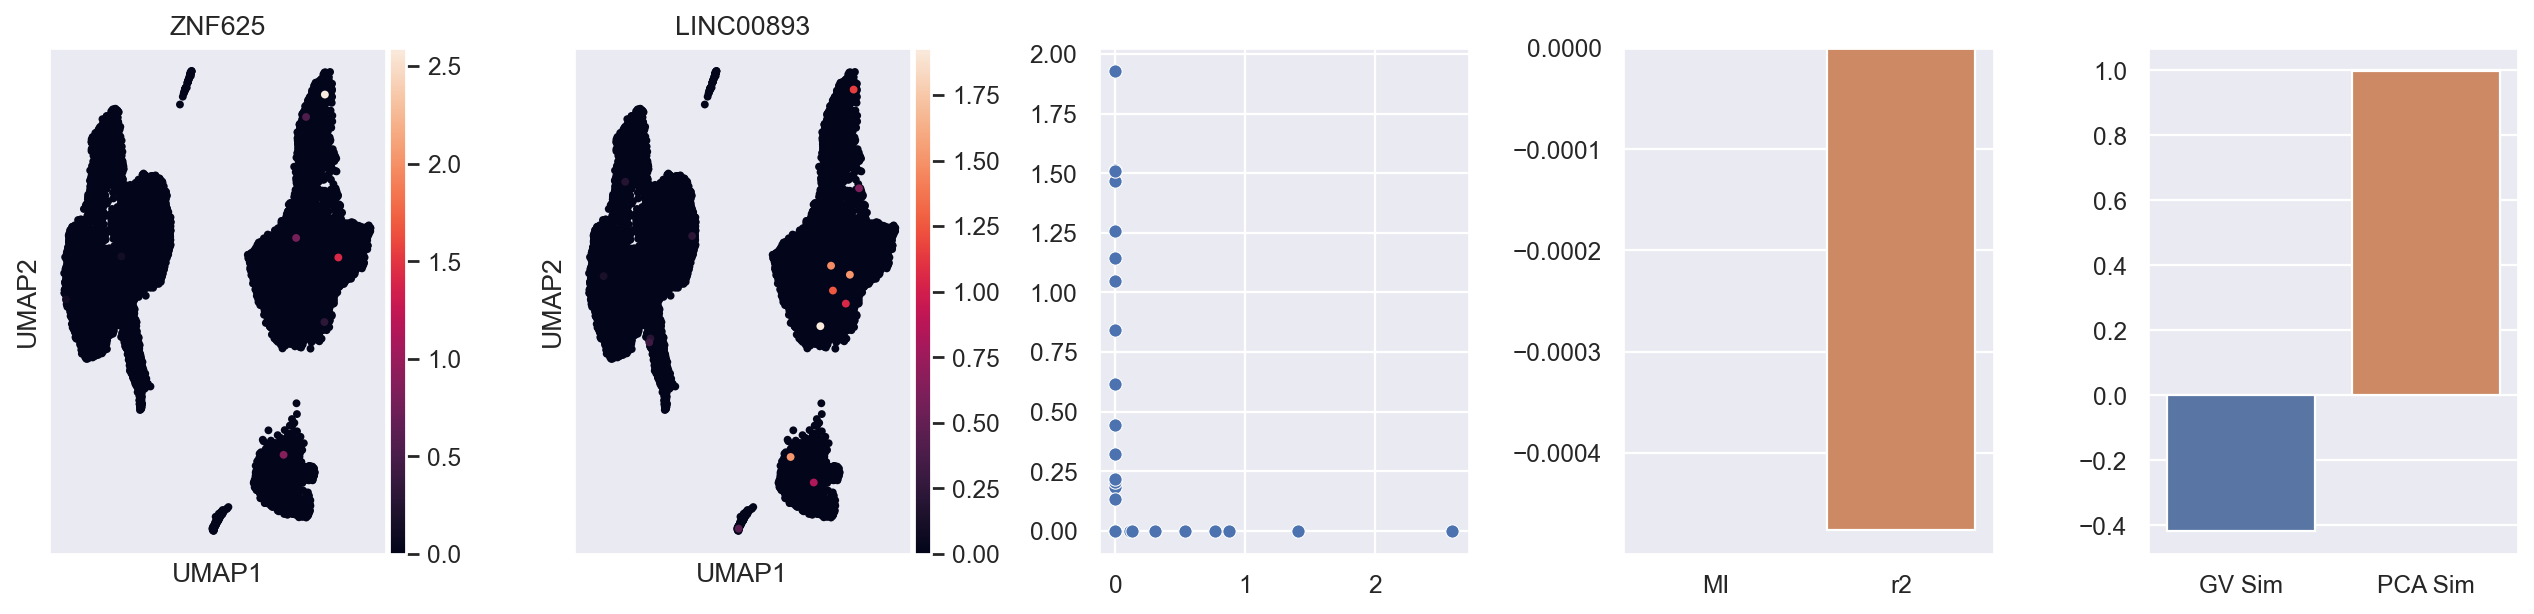

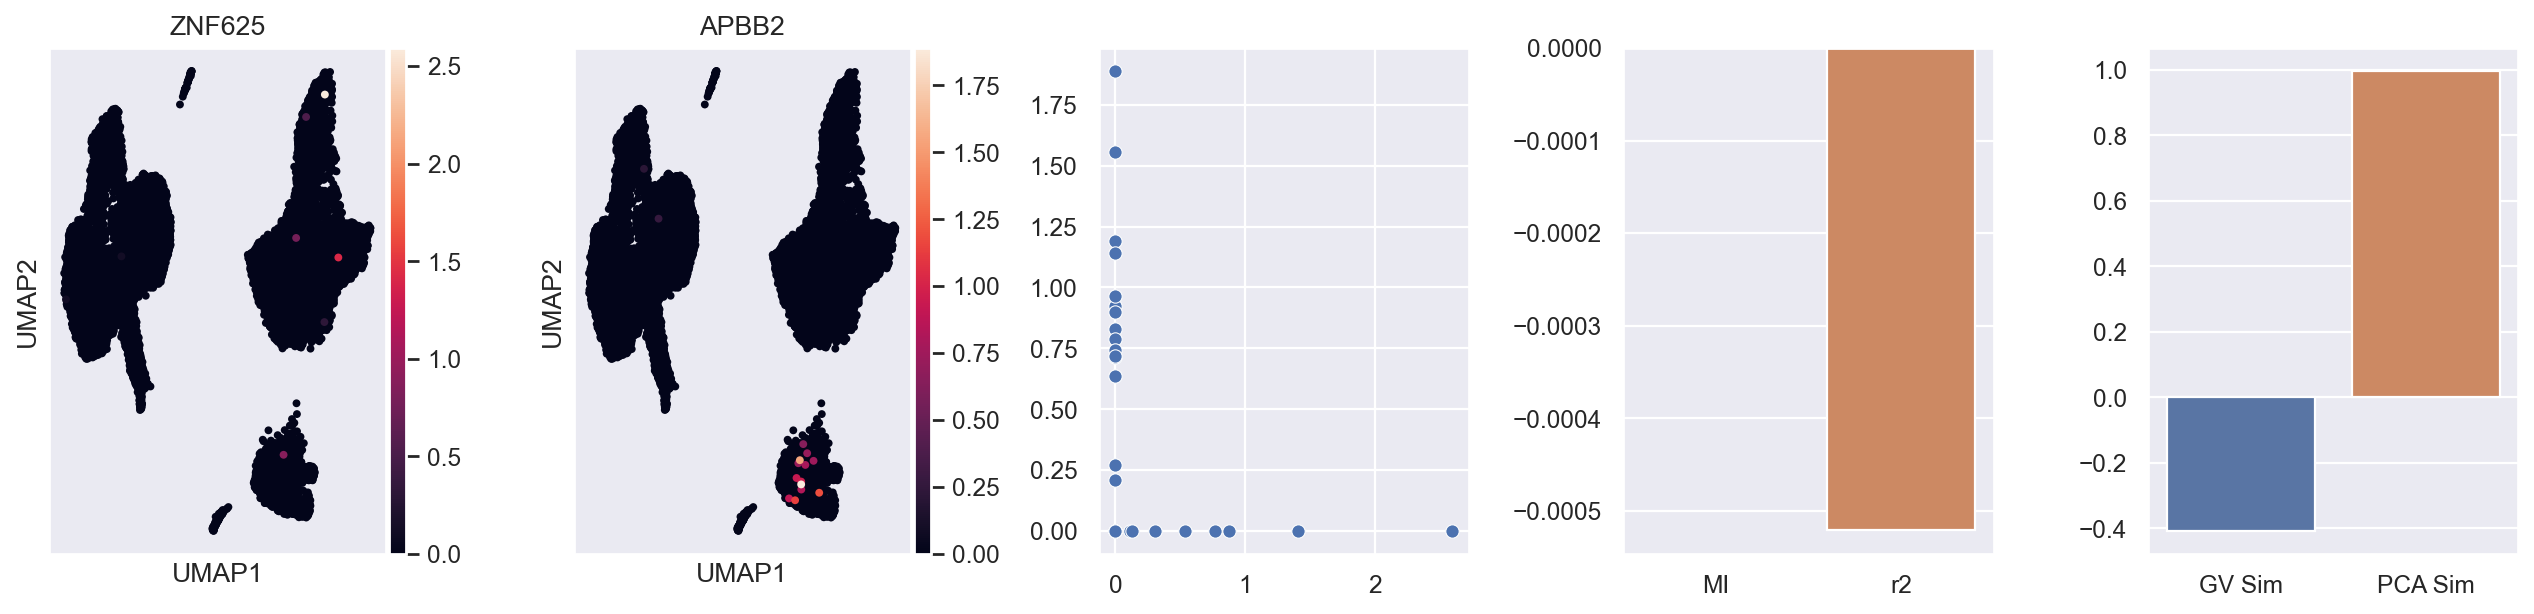

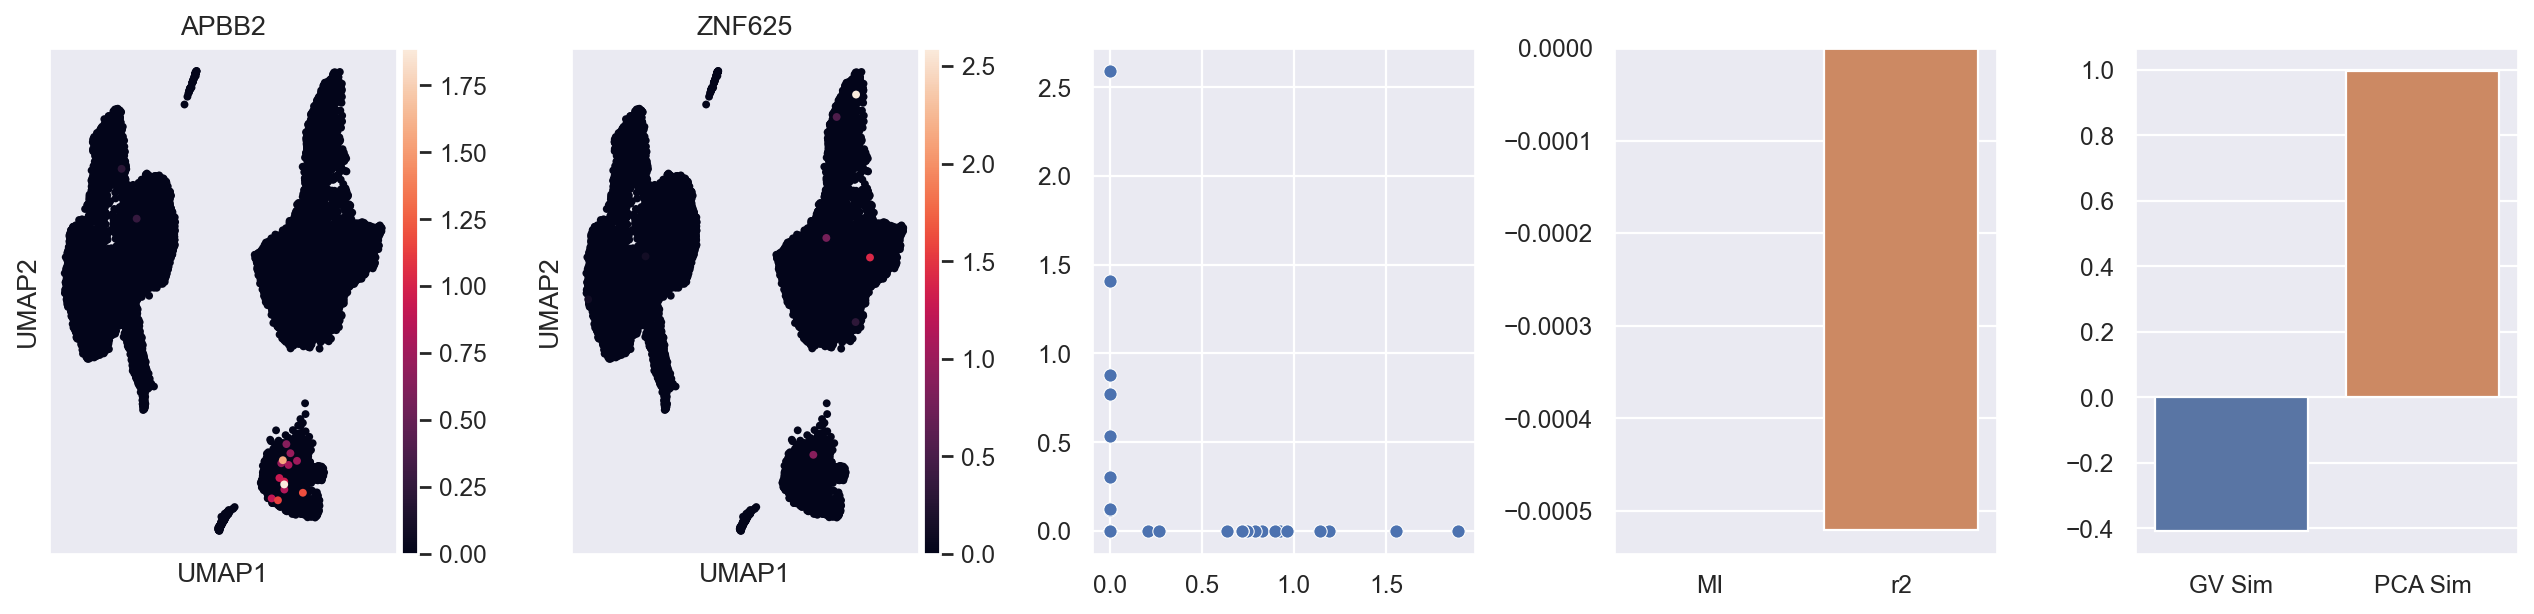

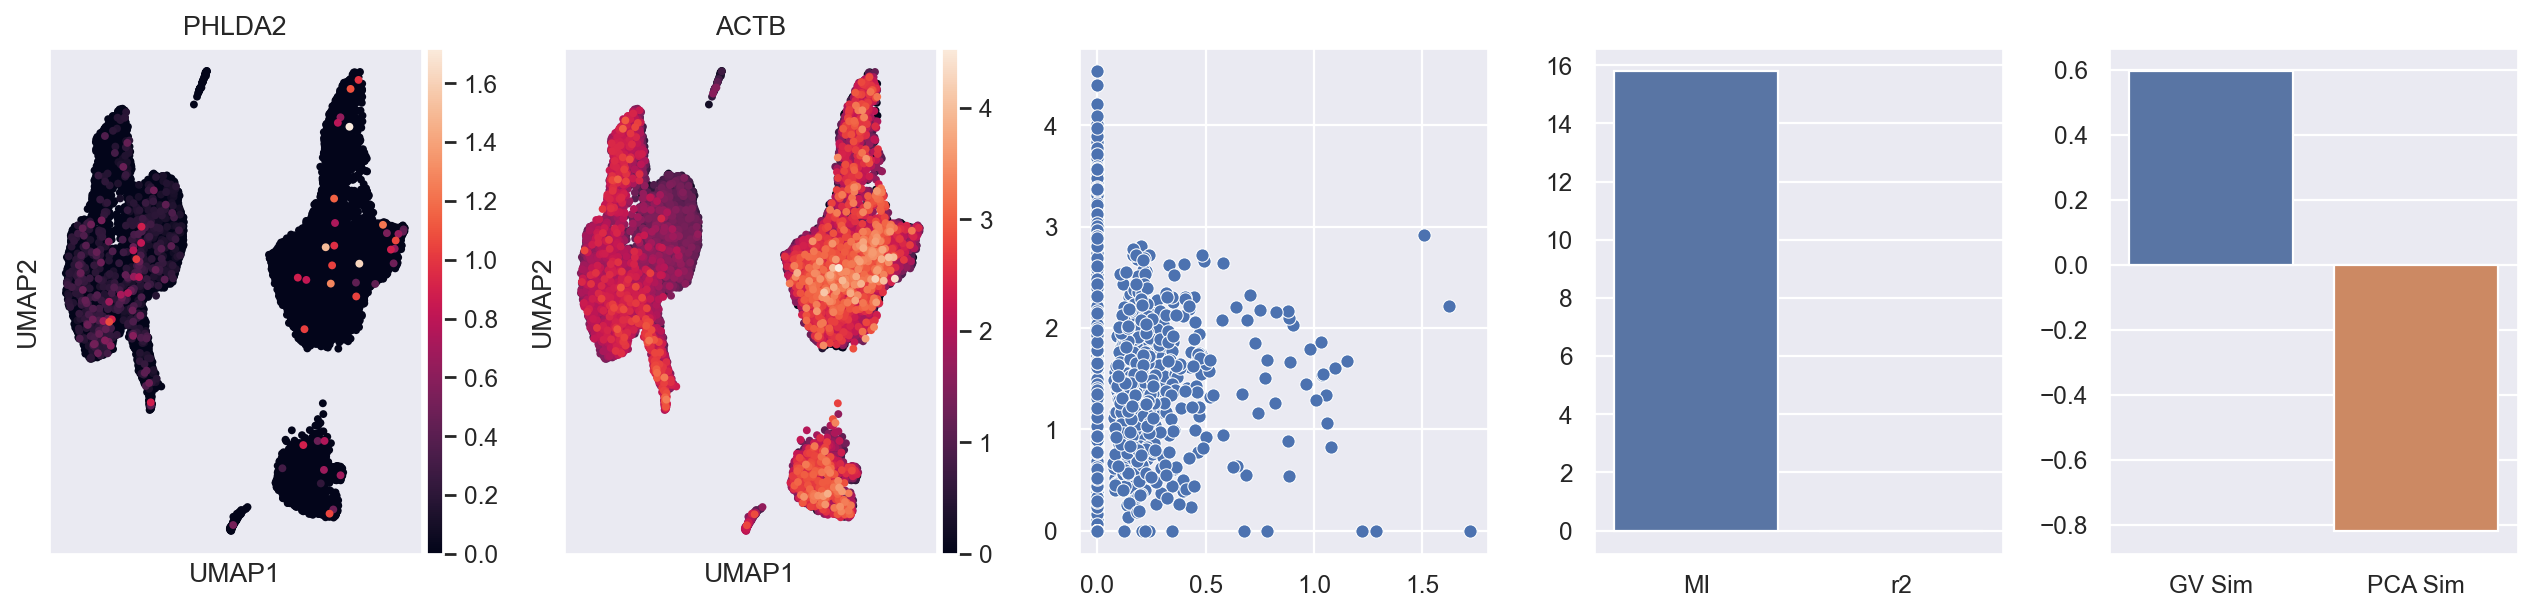

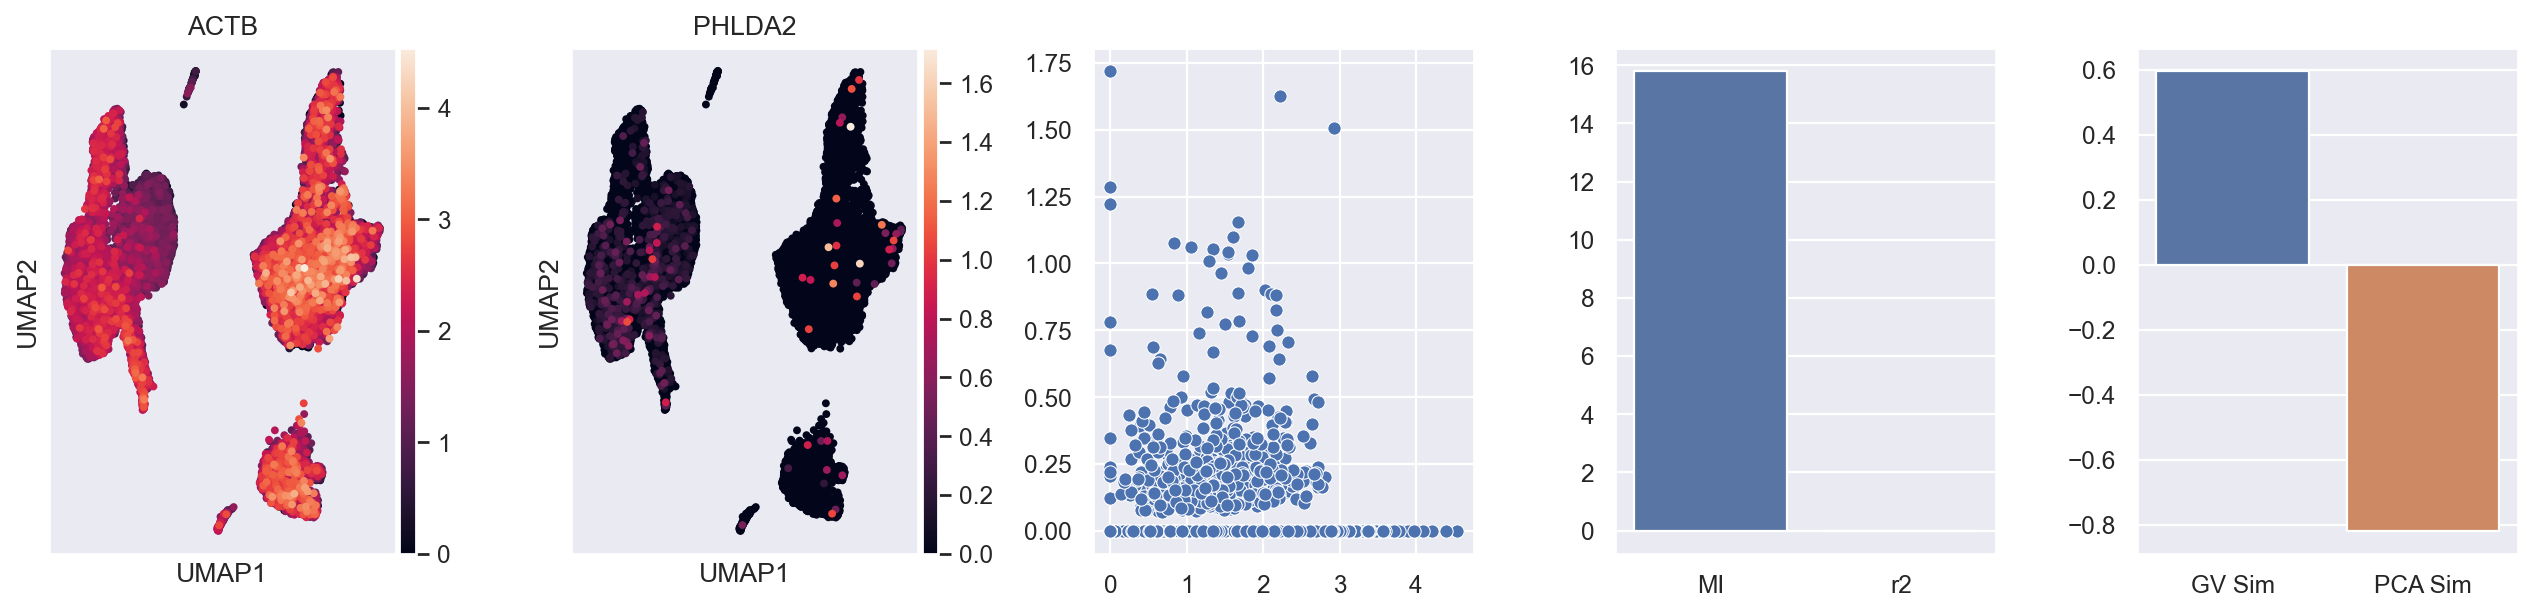

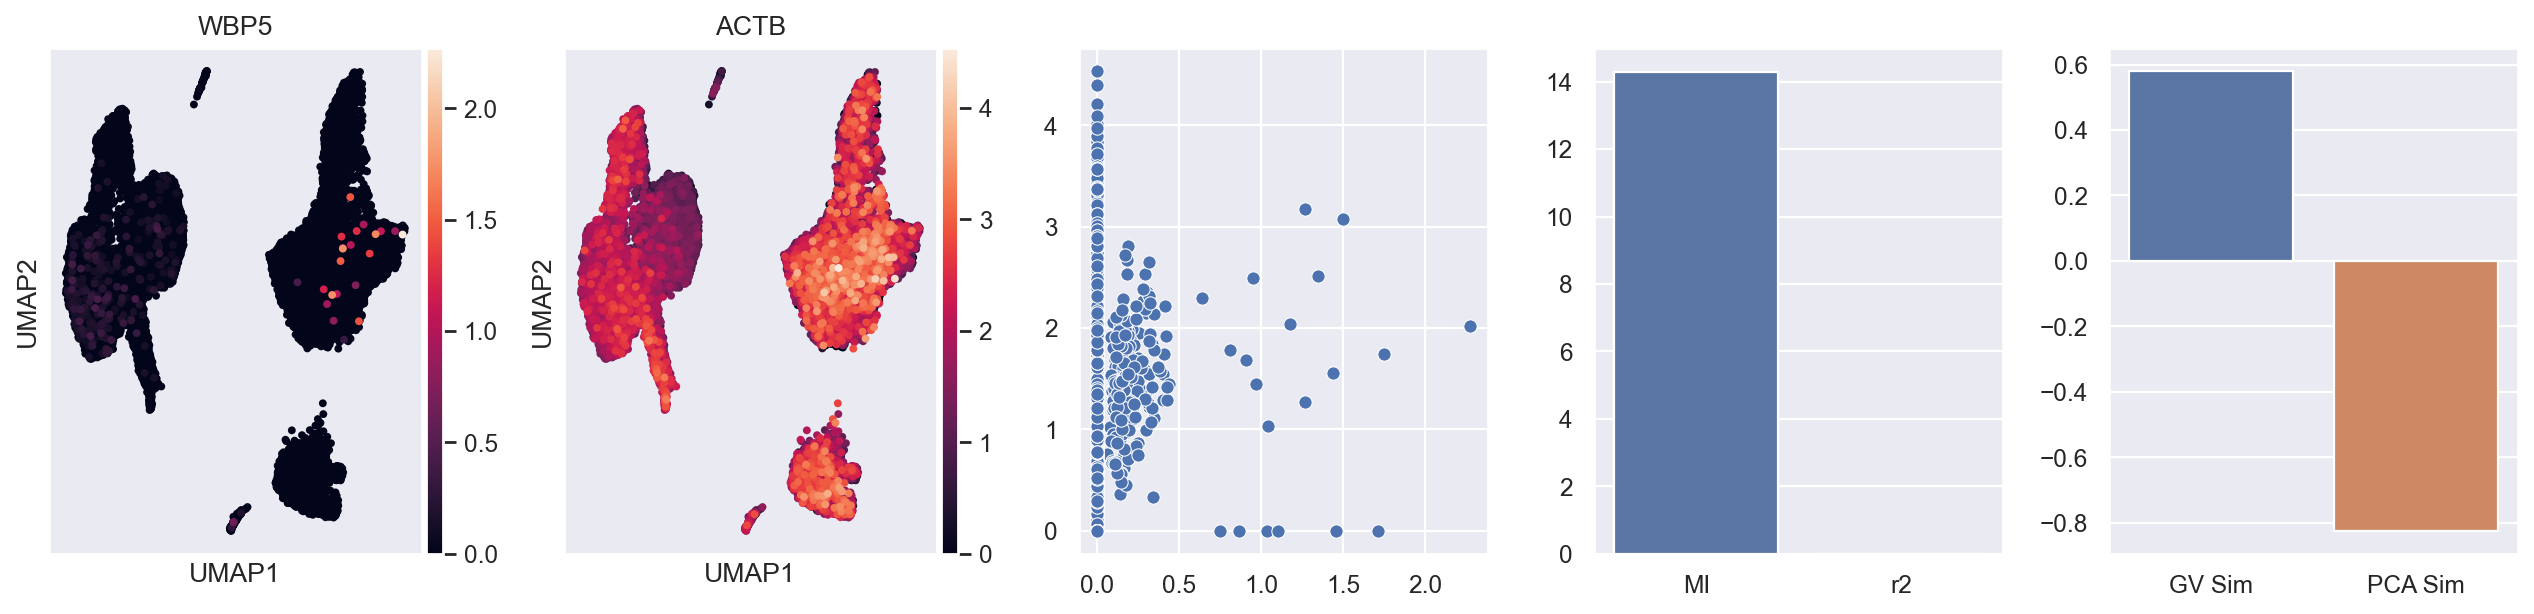

In [74]:
mismatched = df[df["diff"]>1.4]
mismatched = mismatched.sort_values("diff",ascending=True)
mismatched = mismatched.sort_values("p_sim",ascending=False).head(30)
sns.set(font_scale=1.)
i = 0
for x,y,w,z in zip(mismatched["Gene"], mismatched["Target"], mismatched["g_sim"], mismatched["p_sim"]):
    plot_coexpression(x, y, adata, dataset.mi_scores, w, z)
    if i > 5:
        break
    i += 1

In [75]:
from scipy.stats import pearsonr
def correlation(gene1,gene2):
    prof1 = adata.X[:,adata.var.index.tolist().index(gene1)]
    prof2 = adata.X[:,adata.var.index.tolist().index(gene2)]
    r2 = pearsonr(prof1,prof2)
    return r2
import tqdm
x = []
y = []
z = []
for gene, target in zip(df["Gene"],df["Target"]):
    if gene == target: continue
    try:
        r2 = correlation(gene,target)
        y.append(r2.statistic)
        z.append(r2.pvalue)
    except Exception as e:
        print(e)
        y.append(0.)
        z.append(1.)
    mi = dataset.mi_scores[gene][target]
    x.append(abs(mi))

df["MI"] = x
df["R2"] = y
df["R2pv"] = z

KeyboardInterrupt: 

/Users/ceglian/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


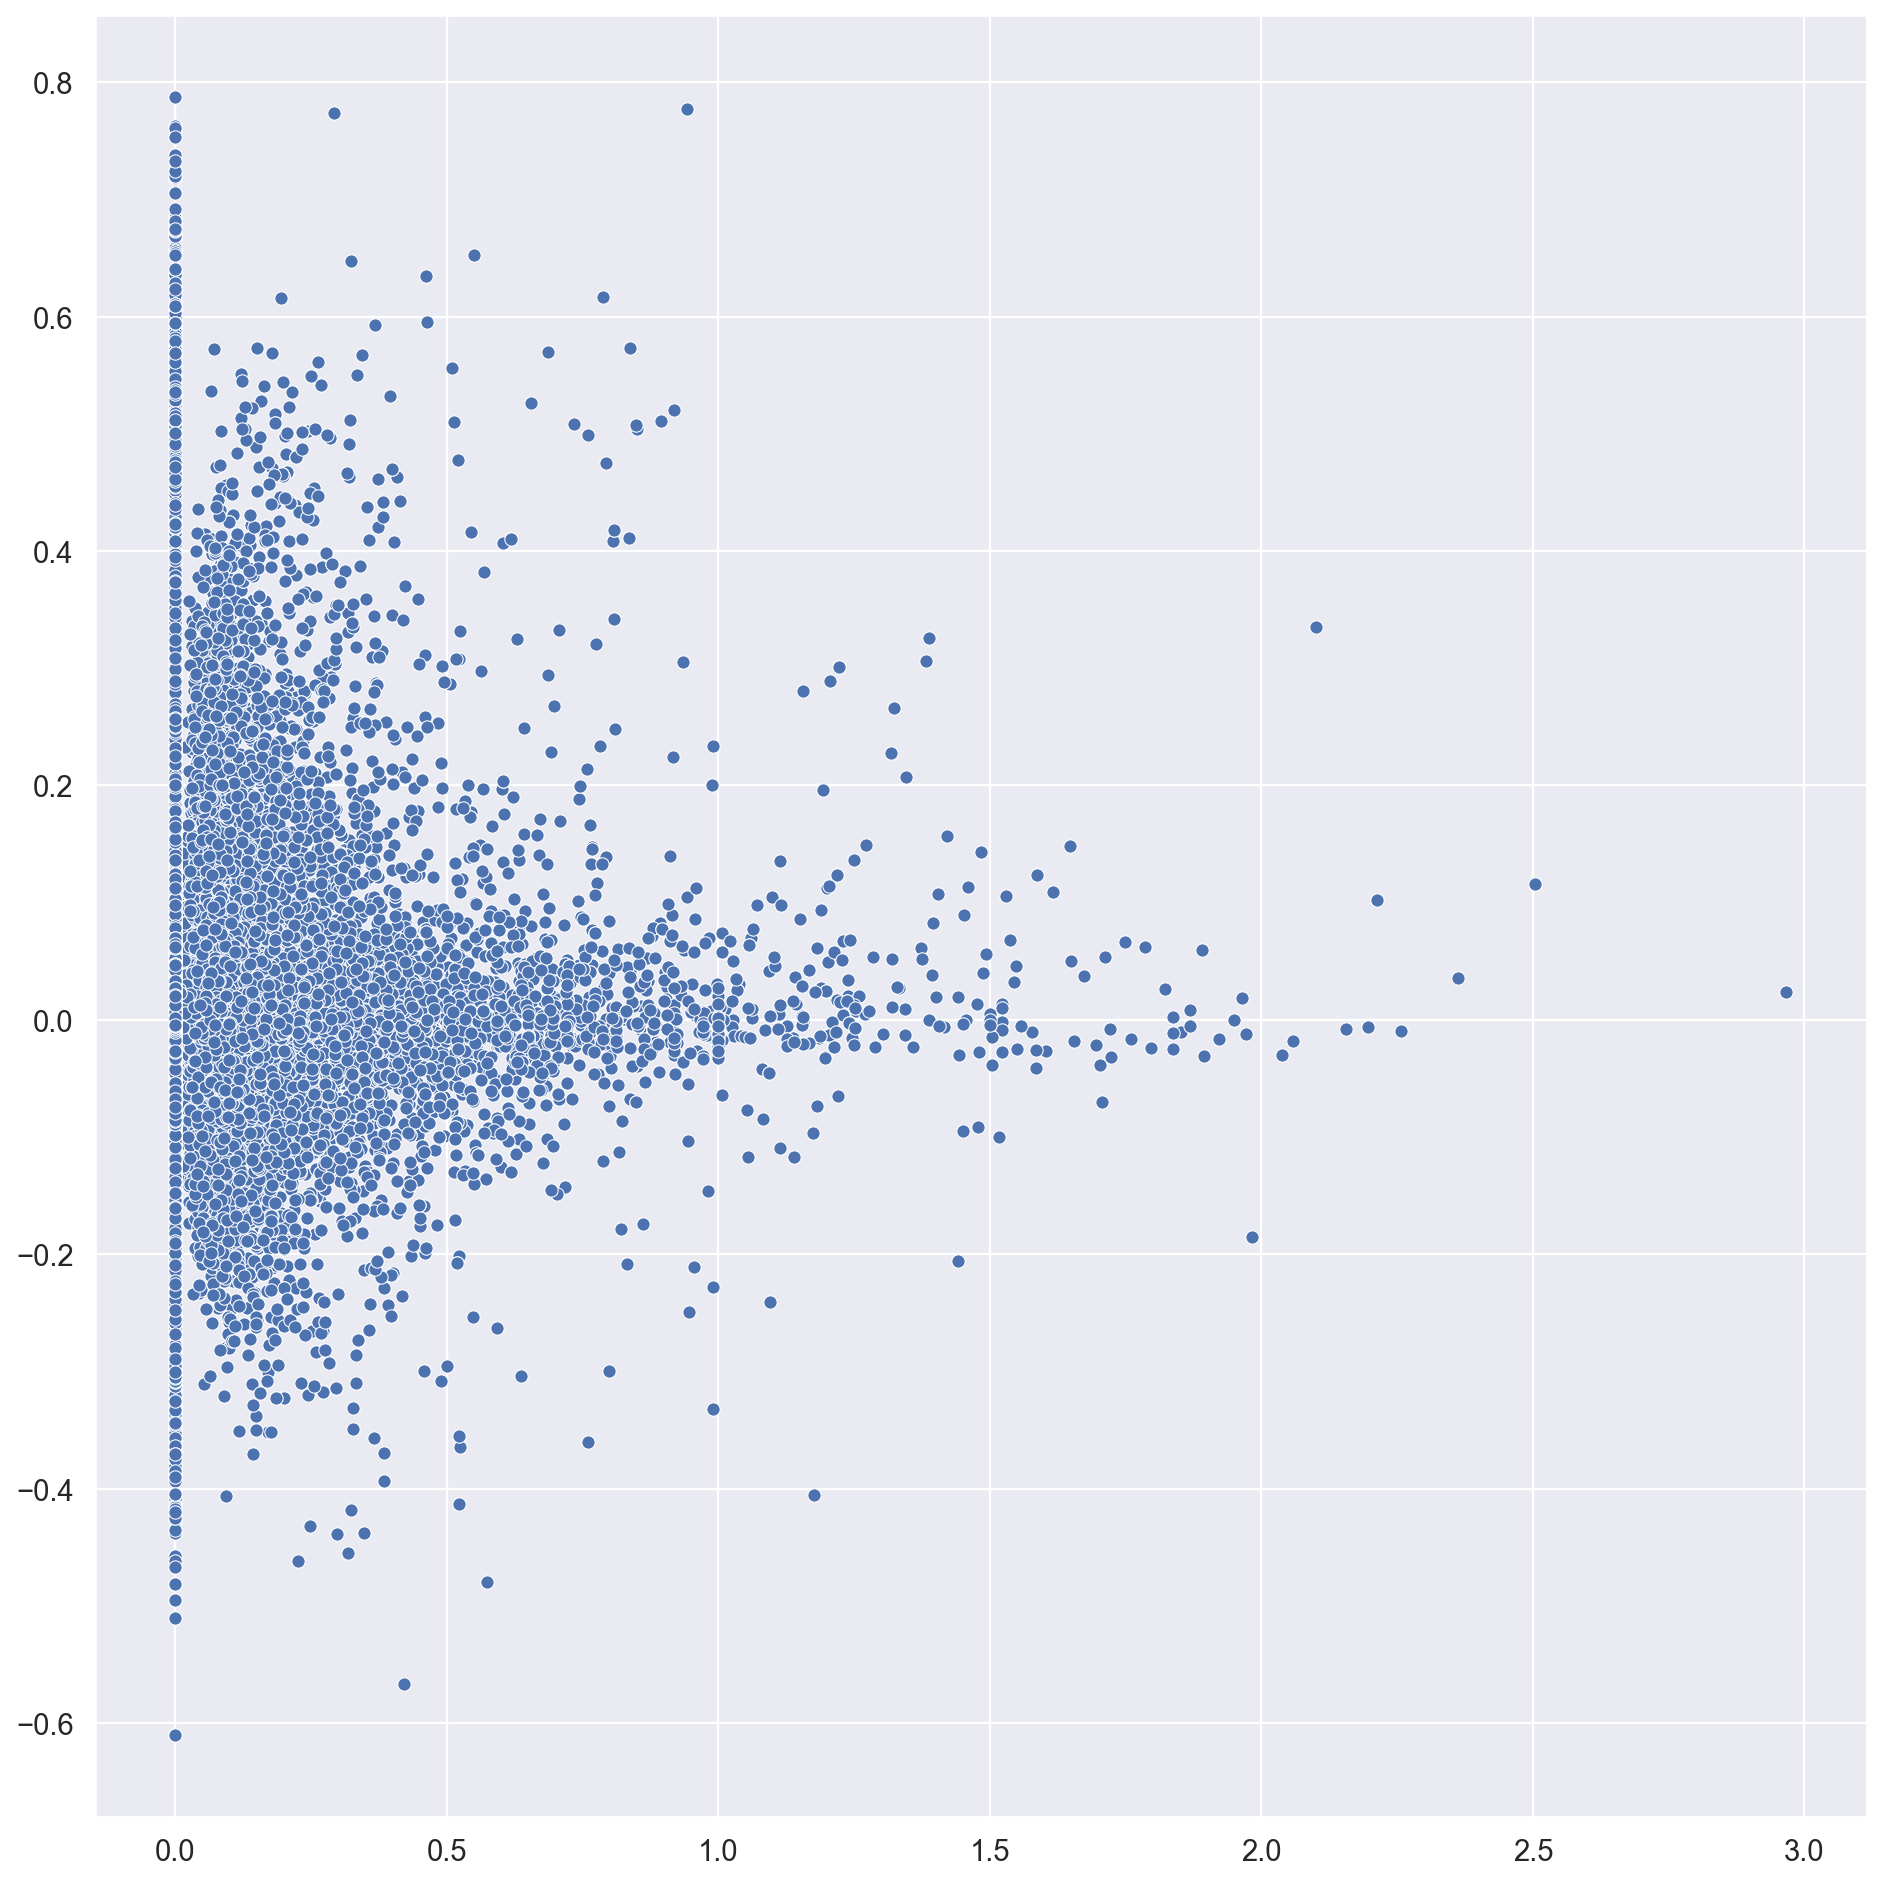

In [44]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.scatterplot(x,y,ax=ax)
plt.tight_layout()

In [ ]:
import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

context = dataset.data
adata = cembed.context.adata
adata.layers["counts"] = adata.X
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

cell_to_gene = list(cembed.context.cell_to_gene.items())
data = collections.defaultdict(list)
weights = collections.defaultdict(list)
pcs = dict()
embed_genes = list(embed.embeddings.keys())
matrix = []

for cell, genes in tqdm.tqdm(cell_to_gene):
    cell_weights = dict(zip(adata.var.index.tolist(),adata.X[adata.obs.index.tolist().index(cell),]))
    weights = []
    vectors = []
    for g,w in cell_weights.items():
        if w != 0.0 and g in embed.embeddings:
            weights.append(w)
            vectors.append(embed.embeddings[g])
    weights = numpy.array(weights)
    cembed.matrix.append(numpy.average(vectors,axis=0,weights=weights))
    cembed.data[cell] = vectors
cembed.dataset_vector = numpy.zeros(numpy.array(cembed.matrix).shape[1])

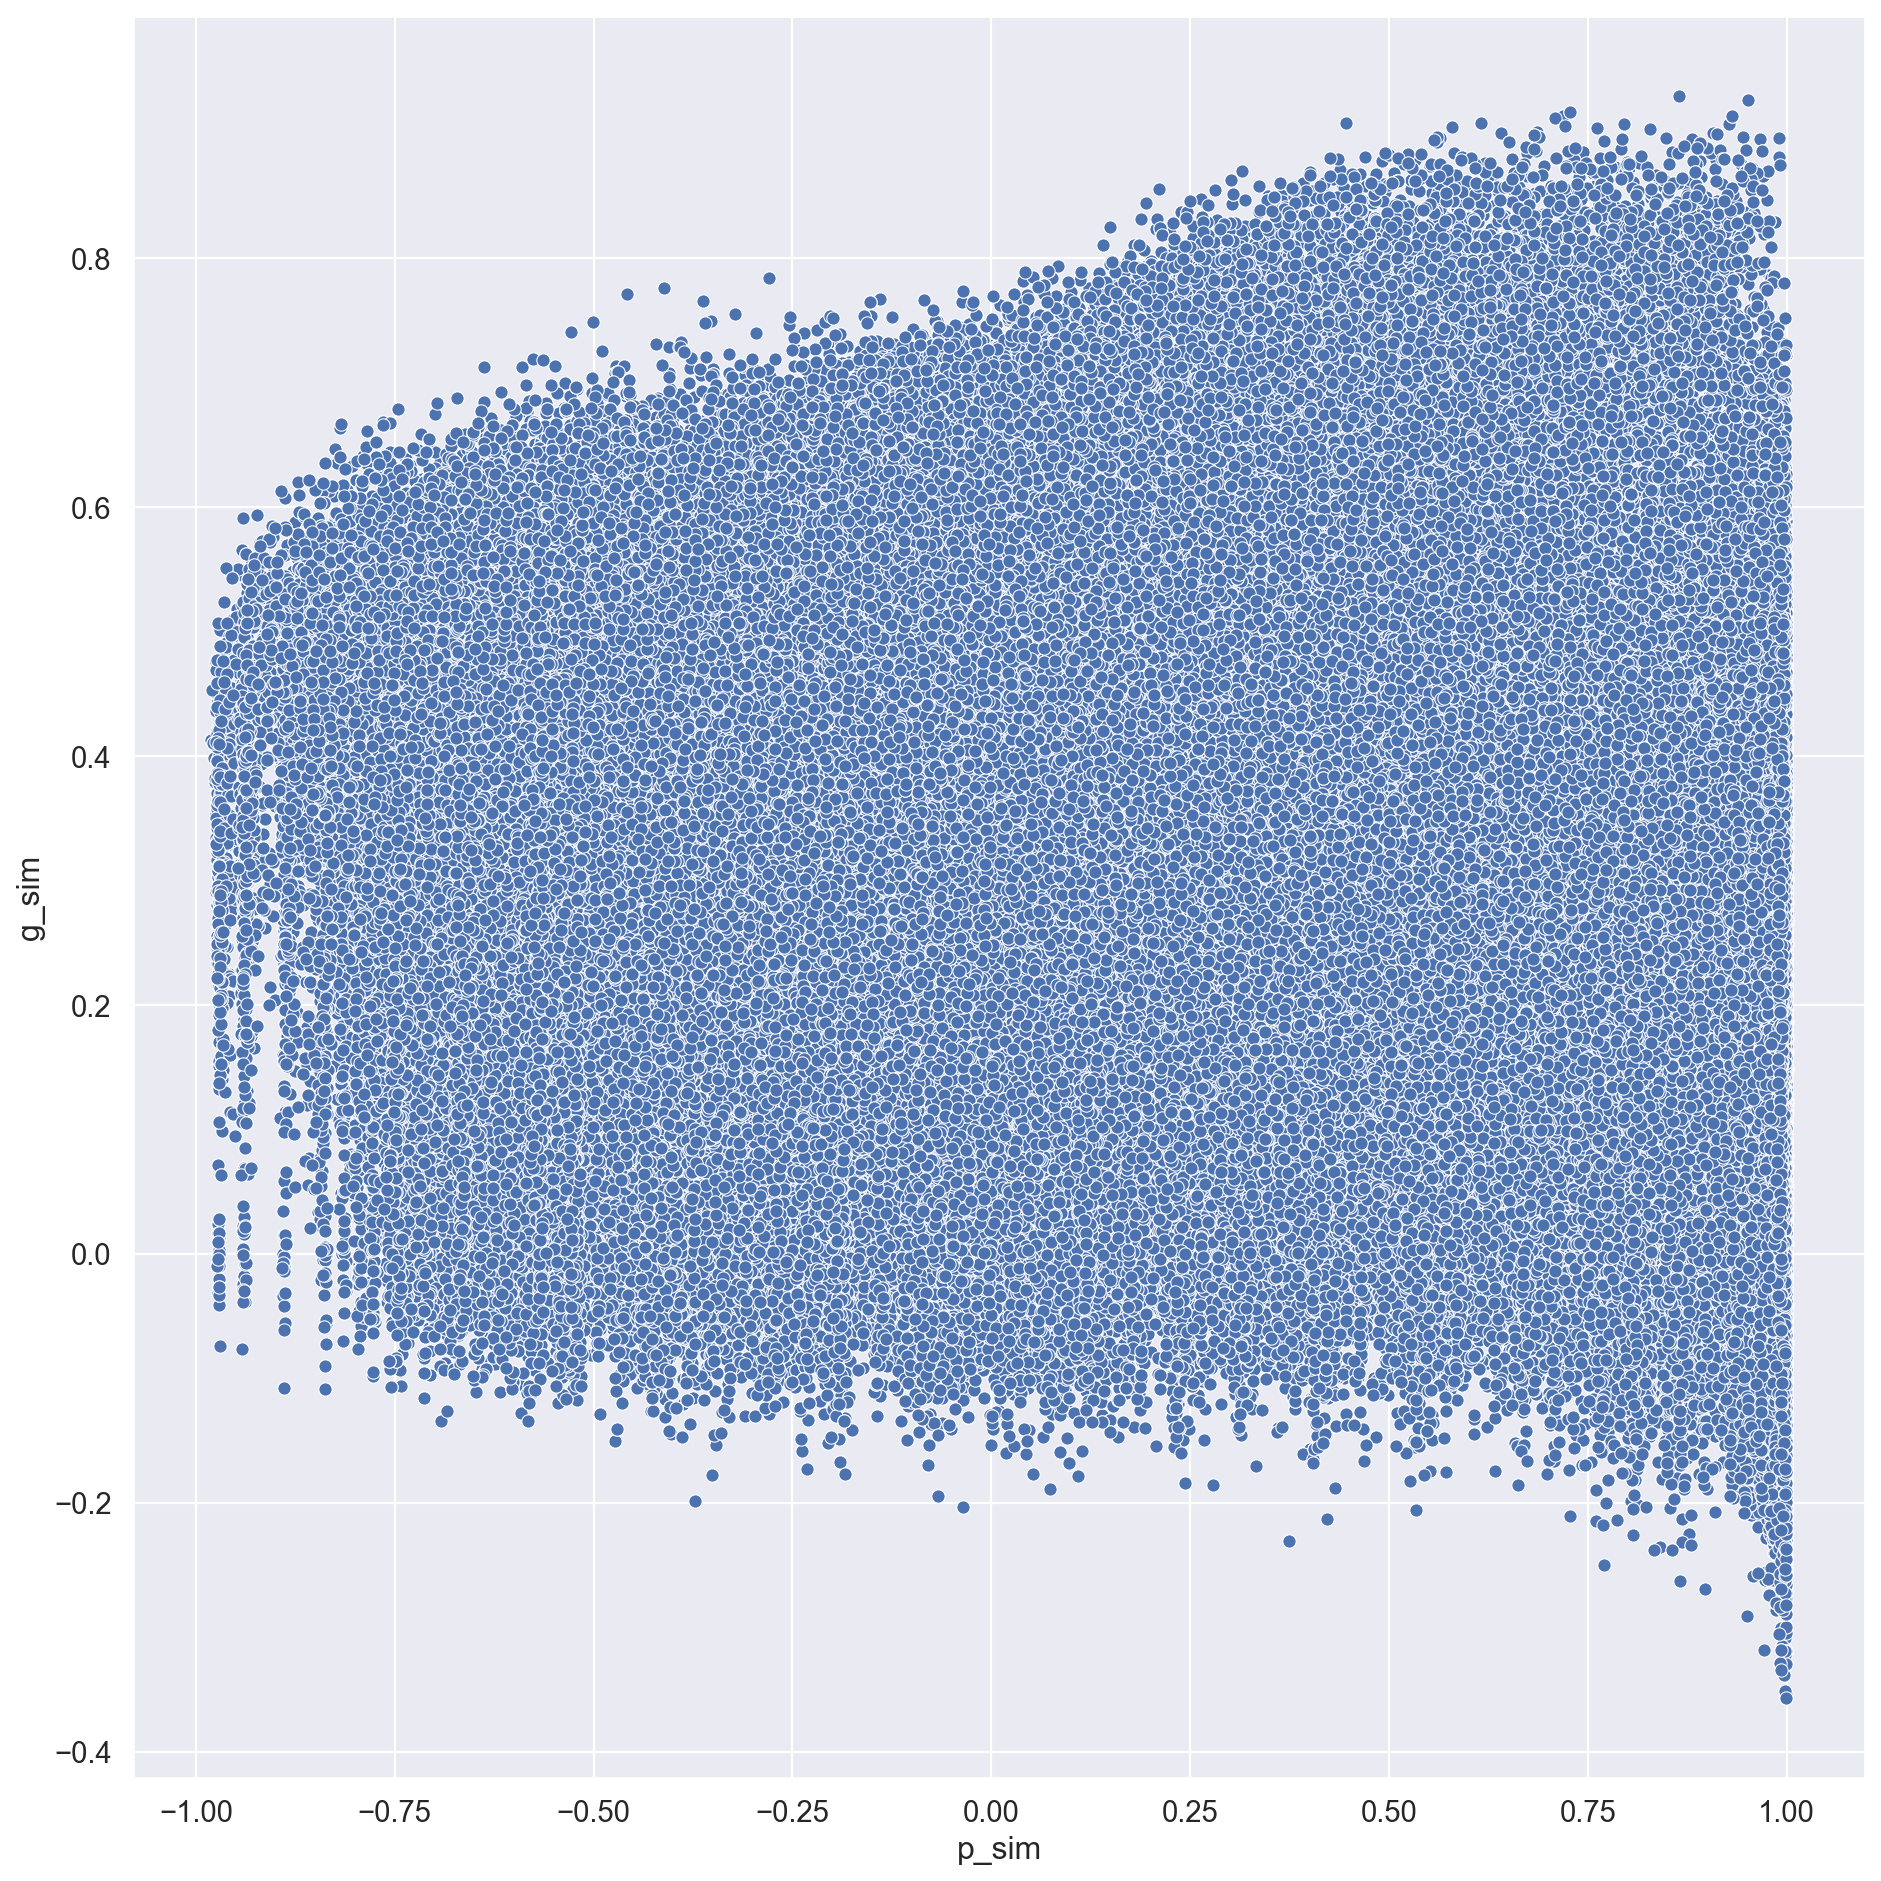

In [45]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.scatterplot(data=df,x="p_sim",y="g_sim",ax=ax)
plt.tight_layout()

In [62]:
dfx = df[df["diff"] > 1.5]
dfx


Gene         Target     g_sim     p_sim      diff   MI  \
11773   RP11-169K16.9           TYMP  0.613034 -0.892368  1.505402  0.0   
147369        FAM168B           FTH1  0.565262 -0.941347  1.506609  0.0   
393132       HOTAIRM1           FTH1  0.591032 -0.940792  1.531824  0.0   
600366           FTH1        FAM168B  0.565262 -0.941347  1.506609  0.0   
600477           FTH1       HOTAIRM1  0.591032 -0.940792  1.531824  0.0   
600661           FTH1          NCOR2  0.551040 -0.961504  1.512544  0.0   
696141          NCOR2           FTH1  0.551040 -0.961504  1.512544  0.0   
696142          NCOR2            FTL  0.593437 -0.922655  1.516093  0.0   
924397            FTL          NCOR2  0.593437 -0.922655  1.516093  0.0   
965008           TYMP  RP11-169K16.9  0.613034 -0.892368  1.505402  0.0   

              R2          R2pv  
11773  -0.042448  4.870682e-07  
147369  0.013505  1.095690e-01  
393132  0.016040  5.737861e-02  
600366  0.013505  1.095690e-01  
600477  0.016040  5.737861e-02  
600661  0.007913  3.485026e-01  
696141  0.007913  3.485026e-01  
696142  0.019208  2.285555e-02  
924397  0.019208  2.285555e-02  
965008 -0.042448  4.870682e-07

In [63]:
def plot_coexpression(gene1, gene2, adata):
    prof1 = adata.X[:,adata.var.index.tolist().index(gene1)]
    prof2 = adata.X[:,adata.var.index.tolist().index(gene2)]
    fig,ax = plt.subplots(1,3,figsize=(16,4))
    sc.pl.umap(adata, color=[gene1], ax=ax[0], size=200, show=False)
    sc.pl.umap(adata, color=[gene2], ax=ax[1], size=200, show=False)
    sns.scatterplot(prof1,prof2,ax=ax[2])
    plt.tight_layout()
for x,y in zip(df["Gene"],df["Target"]):
    plot_coexpression(x,y,adata)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


/Users/ceglian/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

KeyboardInterrupt: 

In [55]:
z = []
for gene, target in zip(df["Gene"],df["Target"]):
    z.append(distances[gene][target])
df["p_sim"] = z

In [56]:
embedding = gdata.obsm["X_pca"]
distances = collections.defaultdict(dict)
targets = gdata.obs.index.tolist()
for mtarget in targets:
    tembed = embedding[gdata.obs.index.tolist().index(mtarget)]
    for target in targets:
        v = embedding[gdata.obs.index.tolist().index(target)]
        x = numpy.array(tembed).reshape(1, -1)
        y = numpy.array(v).reshape(1, -1)
        distance = np.sum(np.square(x - y))
        distances[mtarget][target] = distance

In [57]:
embedding = gdata.obsm["X_pca"]
distances = collections.defaultdict(dict)
targets = gdata.obs.index.tolist()
for mtarget in targets:
    tembed = embedding[gdata.obs.index.tolist().index(mtarget)]
    for target in targets:
        v = embedding[gdata.obs.index.tolist().index(target)]
        x = numpy.array(tembed).reshape(1, -1)
        y = numpy.array(v).reshape(1, -1)
        distance = np.sum(np.square(x - y))
        distances[mtarget][target] = distance
z = []
for gene, target in zip(df["Gene"],df["Target"]):
    z.append(distances[gene][target])
df["p_sim_euc"] = z

In [58]:
df

Gene      Target     g_sim     p_sim      diff        MI        R2  \
0        HES4       ABHD5 -0.075836 -0.109036  0.621822  0.000000 -0.013351   
1        HES4  AC002456.2 -0.012644 -0.064315  0.668851  0.000000  0.003908   
2        HES4  AC006129.4  0.028370 -0.059151  0.685996  0.067964  0.015528   
3        HES4  AC022182.3  0.003992 -0.113548  0.634852  0.000000 -0.010998   
4        HES4  AC062029.1  0.003977 -0.069634  0.676395  0.000000 -0.008079   
...       ...         ...       ...       ...       ...       ...       ...   
974164  S100B       ZNF80  0.381940  0.803342  1.038736  0.000000 -0.004104   
974165  S100B      ZNF846 -0.088018  0.826607  0.584382  0.000000  0.012473   
974166  S100B      ZNF852  0.138744  0.817236  0.794824  0.000000  0.001721   
974167  S100B     ZSCAN29 -0.012818  0.810654  0.655497  0.000000 -0.004215   
974168  S100B       ZWINT  0.179327  0.822912  0.838609  0.000000  0.020026   

            R2pv  p_sim_euc  
0       0.113697  29.089518  
1       0.643353  30.726109  
2       0.065798  30.373592  
3       0.192566  30.576296  
4       0.338494  31.115582  
...          ...        ...  
974164  0.626776   4.854325  
974165  0.139461   4.122317  
974166  0.838467   4.412627  
974167  0.617497   4.657510  
974168  0.017651   4.351140  

[973182 rows x 9 columns]

In [93]:
dfx = df[df["g_sim"] > 0.85]
dfx = dfx[dfx["p_sim_euc"]< 200.0]
dfx = dfx[dfx["p_sim"]< 0.]
dfx[["Gene","Target",""]]

Gene    Target     g_sim     p_sim      diff        MI        R2  \
115508       ID2     ALDH2  0.855909 -0.235389  1.525686  0.362377  0.014956   
117235    FAM49A  SERPINB1  0.866979 -0.102994  0.310121  0.213044  0.059768   
322038  SERPINB1    FAM49A  0.866979 -0.102994  1.311094  0.213044  0.059768   
322136  SERPINB1  HLA-DRB5  0.868549 -0.220115  1.450863  0.450040  0.017596   
348193  HLA-DRB5  SERPINB1  0.868549 -0.220115  0.311691  0.450040  0.017596   
690313     ALDH2       ID2  0.855909 -0.235389  0.710734  0.362377  0.014956   

                R2pv   p_sim_euc  
115508  7.638503e-02   90.903381  
117235  1.366959e-12  131.472336  
322038  1.366959e-12  131.472336  
322136  3.708075e-02  139.516129  
348193  3.708075e-02  139.516129  
690313  7.638503e-02   90.903381

Text(20.0, 0.5, 'PCA Cosine Similarity')

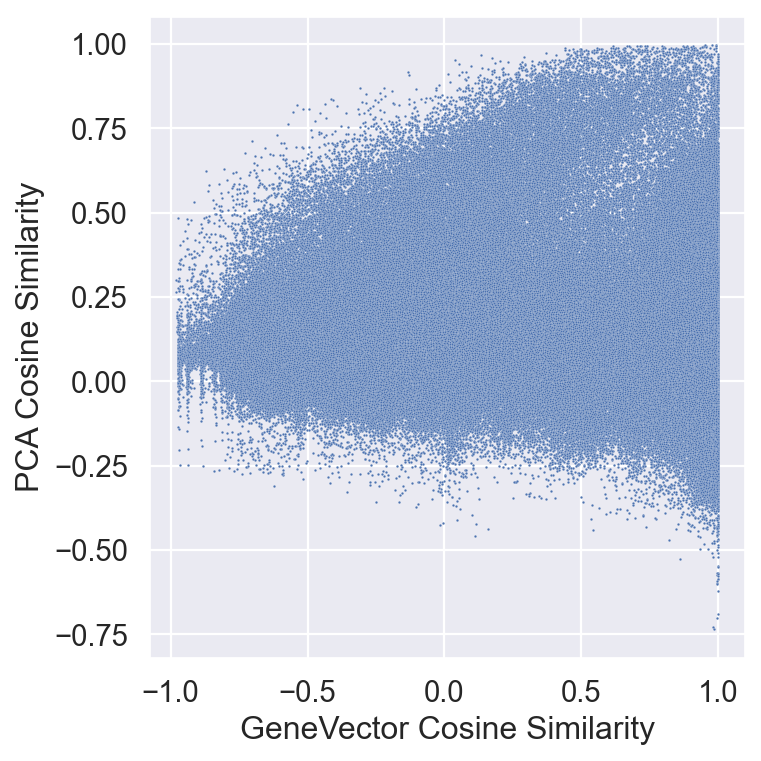

In [113]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data=df,x="p_sim",y="g_sim",ax=ax,s=1)
plt.tight_layout()
plt.xlabel("GeneVector Cosine Similarity")
plt.ylabel("PCA Cosine Similarity")

/Users/ceglian/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


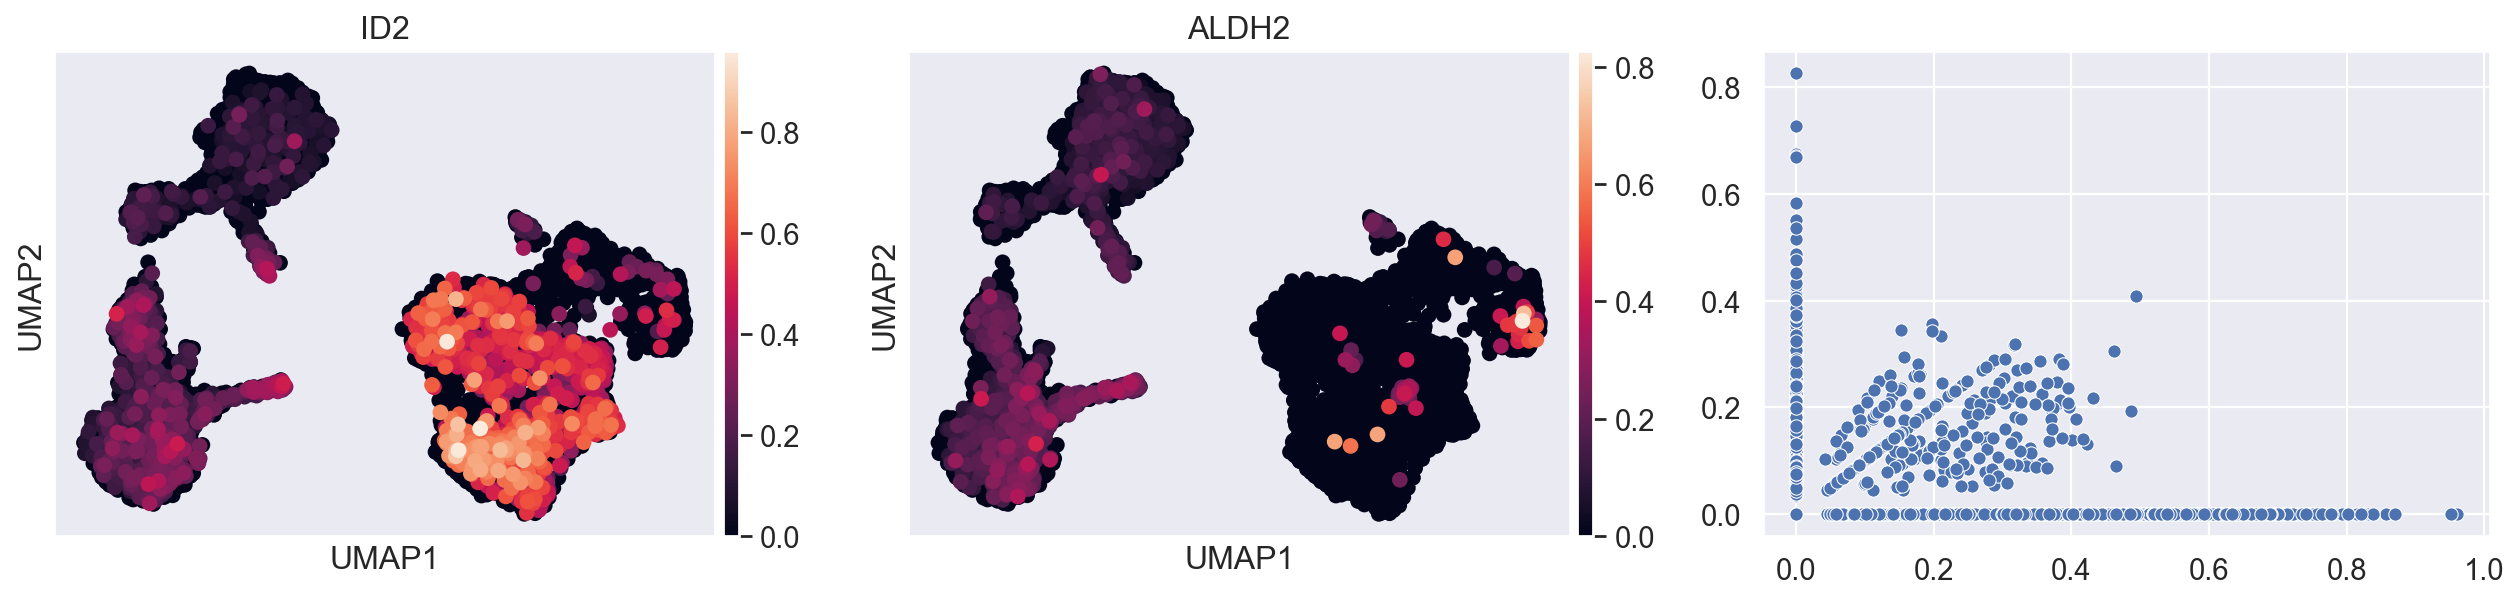

In [94]:
plot_coexpression("ID2","ALDH2",adata)

/Users/ceglian/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


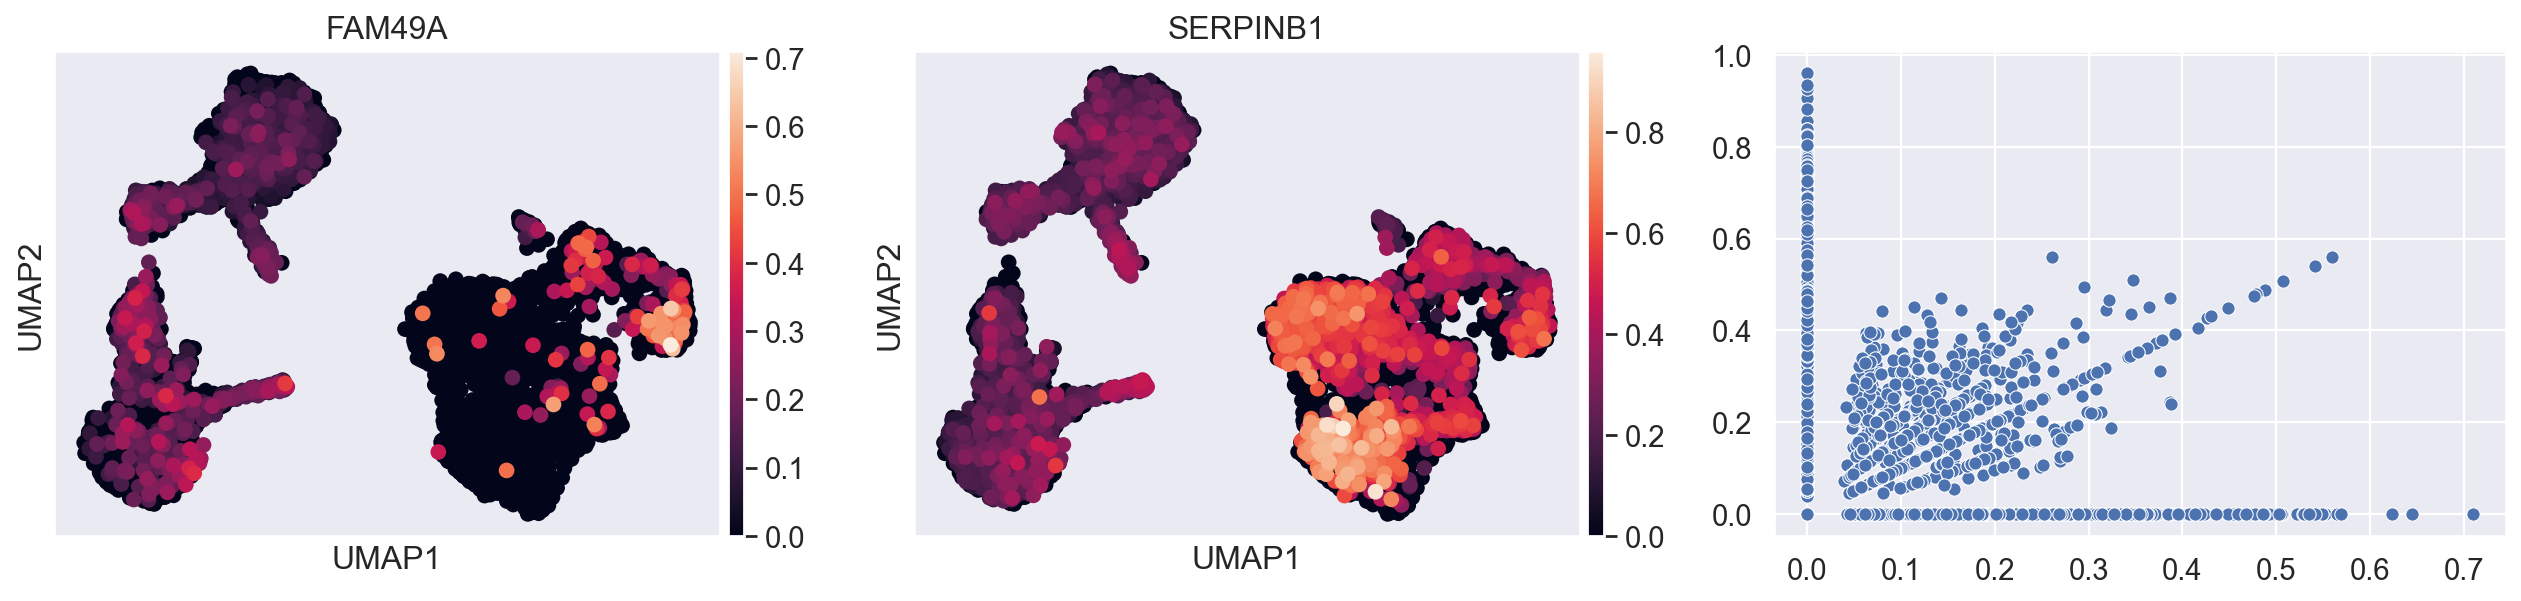

In [95]:
plot_coexpression("FAM49A","SERPINB1",adata)

/Users/ceglian/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


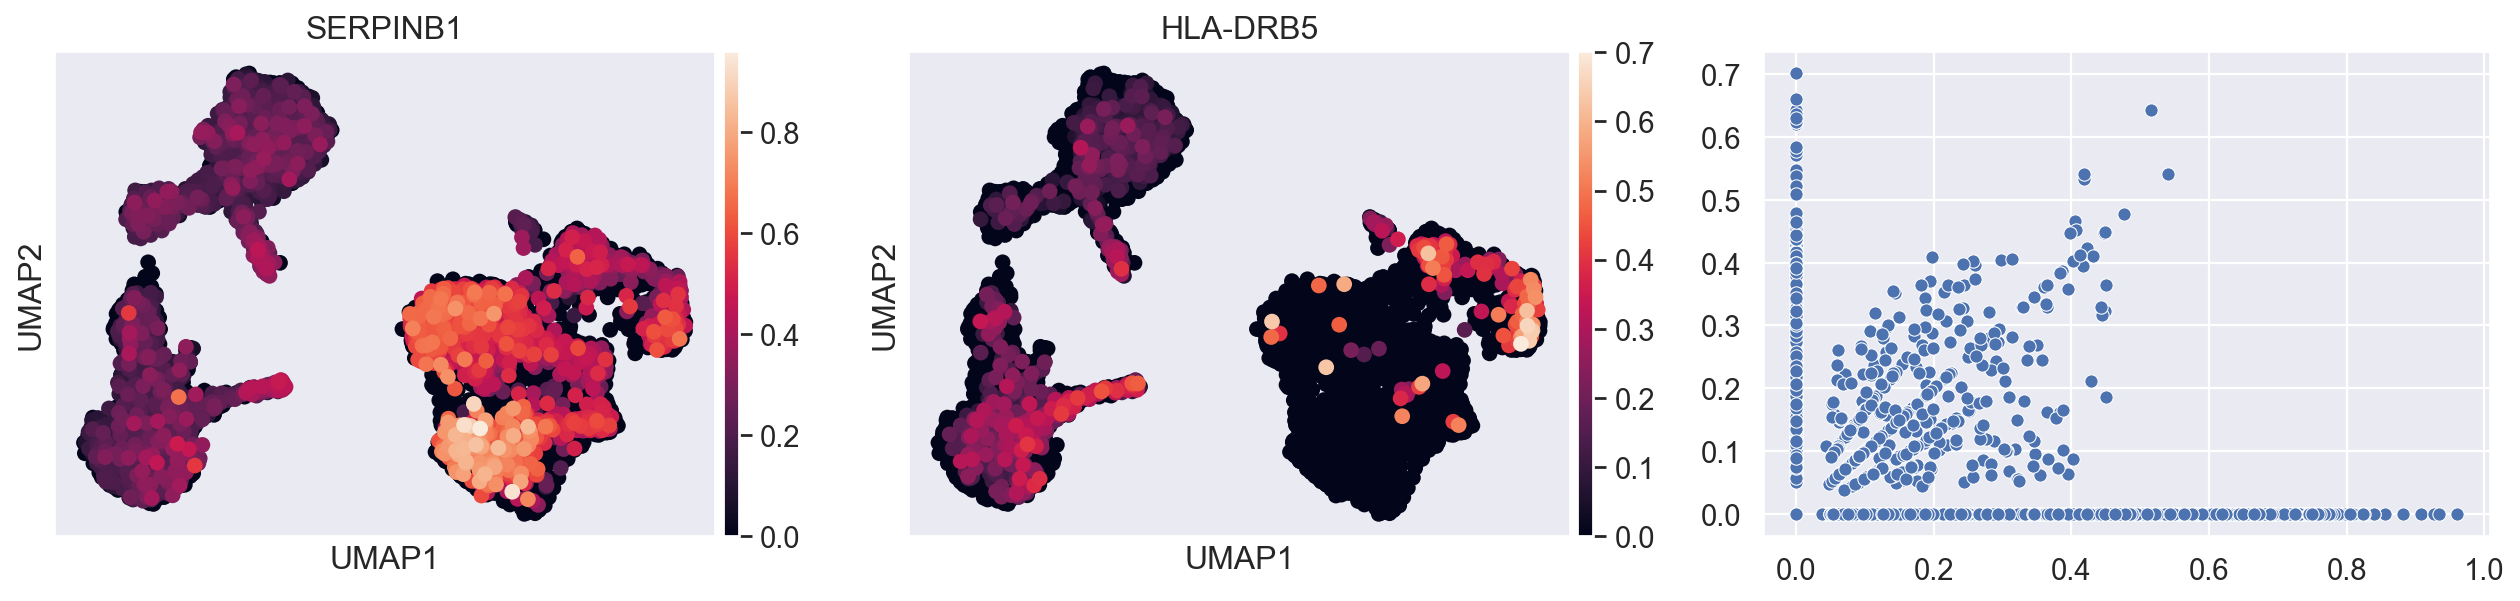

In [96]:
plot_coexpression("SERPINB1","HLA-DRB5",adata)

Text(0, 0.5, 'Number of Gene Pairs')

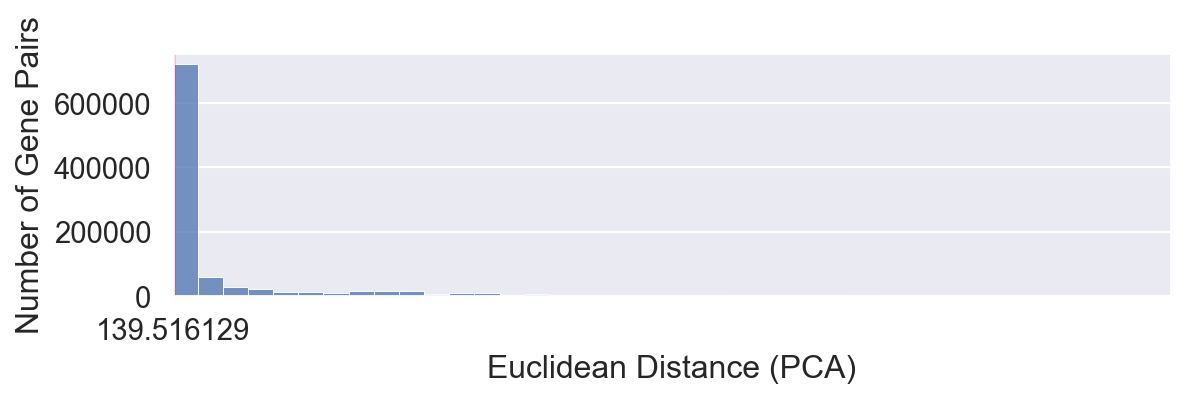

In [108]:
fig, ax = plt.subplots(1,1,figsize=(8,2))
sns.histplot(df["p_sim_euc"],bins=100, ax=ax)
ax.set_xlim(0,5000)
ax.axvline(x="139.516129",color="red")
ax.set_xlabel("Euclidean Distance (PCA)")
ax.set_ylabel("Number of Gene Pairs")

In [91]:
embedding = gdata.obsm["X_pca"]
source = "GPR137B"
target = "BIRC3"
source = embedding[gdata.obs.index.tolist().index(source)]
target = embedding[gdata.obs.index.tolist().index(target)]

print(numpy.var(source))
print(numpy.var(target))

print()

for pc1, pc2 in zip(source,target):
    print(abs(pc1-pc2))

0.09673259
28.228907

15.912979
13.222511
9.746327
2.2240226
5.340961
4.437271
1.9393752
2.2454915
6.620271
7.5518517
13.876681
2.495198
8.19549
0.5533477
1.5884328
2.6232567
0.63622916
9.2414665
12.983526
10.037626
2.5032651
5.8644304
5.4600477
1.3627833
1.3108039
0.45386672
2.1872363
6.5449433
1.1131322
2.843834
1.8718941
0.047140762
0.04761581
0.1416515
1.5773435
0.95015323
1.0992419
1.7058494
0.8798877
2.0015044
0.62315214
0.6649817
0.13175137
1.4169146
1.5422034
0.25332654
0.82205534
1.4917881
0.44172084
1.0739238


In [90]:
targets = list(embed.embeddings.keys())

source = "GPR137B"
target = "BIRC3"

source = embed.embeddings[source]
target = embed.embeddings[target]
print(numpy.var(source))
print(numpy.var(target))

print()
for pc1, pc2 in zip(source,target):
    print(abs(pc1-pc2))

1.3754418807504183
6.6999019971613265

0.7568774250000001
1.2156686999999997
0.182689375
2.9564411
1.6155038849999999
0.390299923
2.19465809
0.63347881
0.2118304199999999
1.4694470049999997
1.27728602
0.4330591549999998
1.030266665
1.4100143
0.727147
1.82668085
1.4035112299999999
2.43782295
1.3668716700000003
0.366354433
0.31870494500000013
0.7342541549999999
2.1788999650000003
0.78874869
1.5054630000000007
1.3733336999999999
0.11361978500000003
1.1765678400000001
0.11582984000000002
1.56906734
2.091313025
2.0432763499999997
1.902616575
0.96617083
0.47852586500000016
0.20216638249999996
1.5763590650000001
7.168296100000001
0.19774082999999998
1.233893025
0.9878216
1.1383255700000001
1.3391903250000001
0.6993251
1.8969016499999998
0.34714809999999985
2.18553495
0.9712042249999999
0.7849146899999999
2.31834745
2.6330161000000003
1.7586109000000003
0.23208590000000018
3.4971772999999997
1.1195539250000002
1.2279799500000004
0.1051883349999998
0.24254214499999993
0.8078951399999998
0.48198